In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
import pandas as pd

import scipy.sparse as scs
from sklearn.utils.extmath import randomized_svd

In [2]:
def random_matrix(n,m,density):
    A = scs.random(n,m,density)
    return A.toarray()


Rekurencyjna kompresja

In [3]:
class Node:
    def __init__(self, t_min, t_max, s_min, s_max):
        self.t_min = t_min
        self.t_max = t_max
        
        self.s_min = s_min
        self.s_max = s_max
        
        self.rank = None
        
        #[A11, A12]
        #[A21, A22]
        
        self.U = None
        self.S = None
        self.VT = None
        
        self.zeros = False
        
        
        self.children = []
        
        


In [4]:
def is_admissible(matrix, S, r, eps):
    if min(matrix.shape) <= r:
        return True
    
    if S[-1] < eps:
        return True
    
    return False     

In [5]:
def create_tree(matrix, r, eps):
    n, m = matrix.shape

    
    def create_tree_r(t_min, t_max, s_min, s_max):
        nonlocal matrix, r, eps
        
        if not np.any(matrix[t_min:t_max, s_min:s_max]):
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
    
        U,S,V = randomized_svd(matrix[t_min:t_max, s_min:s_max], r)
        
        S = S[S >= eps]  
        rank = len(S)
        
        U = U[:, :rank]
        V = V[:rank, :]
        if rank == 0:
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
        
        
        if is_admissible(matrix[t_min:t_max, s_min:s_max], S, r, eps):
            v = Node(t_min, t_max, s_min, s_max) #compress matrix
            v.rank = rank
            v.U = U
            v.S = S
            v.V = V
            return v
            
        else:
            v = Node(t_min, t_max, s_min, s_max)
            
            t_newmax = (t_min + t_max)//2
            s_newmax = (s_min + s_max)//2
            
            v1 = create_tree_r(t_min, t_newmax, s_min, s_newmax)
            v2 = create_tree_r(t_min, t_newmax, s_newmax, s_max)
            v3 = create_tree_r(t_newmax, t_max, s_min, s_newmax)
            v4 = create_tree_r(t_newmax, t_max, s_newmax, s_max)
            
            v.children = [v1, v2, v3, v4]
        return v
    return create_tree_r(0, n, 0, m)

In [6]:
def decompress(node):
    if node.rank is not None:
        if node.rank > 0:
            return node.U@np.diag(node.S)@node.V
        else:
            return np.zeros((node.t_max - node.t_min, node.s_max - node.s_min))
    else:
        return np.vstack(
            (
                np.hstack((decompress(node.children[0]), decompress(node.children[1]))),
                np.hstack((decompress(node.children[2]), decompress(node.children[3]))),
            )
        )   

In [12]:
s = 2**10
a = scs.random(s,s,density = 0.1)
a = a.toarray()
print(a)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.9338018  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.36043936 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.45906801]
 [0.         0.99780373 0.         ... 0.         0.         0.        ]]


In [13]:
tree = create_tree(a, 2, 10**(-8))
#print(decompress(tree))

In [14]:
print(np.sum(np.square(a - decompress(tree))))

8.543763591997999e-28


Rysowanie

In [10]:
def plot_matrix(root, matrix, title = None):
    size = matrix.shape
    tmap = np.zeros(size)
    
    def fill_map(node):
        nonlocal tmap
        if node.rank is not None:
            if node.rank != 0:
                tmap[node.t_min:node.t_max, node.s_min:node.s_min + node.rank] = 1
                tmap[node.t_min:node.t_min + node.rank, node.s_min:node.s_max] = 1
        else:
            for submatrix in node.children:
                fill_map(submatrix)
    fill_map(root)
    f, ax = plt.subplots(1,1)
    ax.spy(tmap)
    if title is not None:
        ax.set_title(title)
        

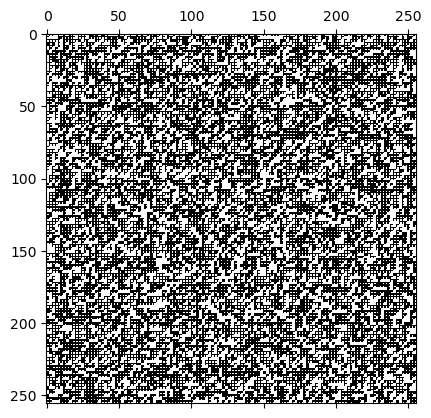

In [11]:
plot_matrix(tree, a)

Pomiary czasu

0.01 256 2 2.414706725471542 0.00600123405456543
0.01 256 2 0.6109648932457602 0.4706137180328369
0.01 256 2 2.467064755974385e-17 0.7059440612792969
0.01 256 4 2.414706725471542 0.0050008296966552734
0.01 256 4 0.6109648932457602 0.3907475471496582
0.01 256 4 2.467064755974385e-17 0.5111534595489502
0.01 256 8 2.414706725471542 0.00400090217590332
0.01 256 8 0.6109648932457602 0.2945842742919922
0.01 256 8 2.467064755974385e-17 0.32277560234069824
0.01 512 2 3.472690369885756 0.005001068115234375
0.01 512 2 0.9816834807422946 0.6991572380065918
0.01 512 2 1.9752413022543685e-16 3.0765061378479004
0.01 512 4 3.472690369885756 0.010055780410766602
0.01 512 4 0.9816834807422946 0.6832485198974609
0.01 512 4 1.9752413022543685e-16 2.1520371437072754
0.01 512 8 3.472690369885756 0.012002706527709961
0.01 512 8 0.9816834807422946 0.6316616535186768
0.01 512 8 1.9752413022543685e-16 1.316622257232666
0.01 1024 2 5.882121934977116 0.01227879524230957
0.01 1024 2 1.4098876561276805 0.775680303

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7212\3850747785.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(1,1)


0.01 1024 4 1.4098876561276805 0.7453217506408691
0.01 1024 4 0.0007862499559859203 8.146851062774658
0.01 1024 8 5.882121934977116 0.03300738334655762
0.01 1024 8 1.4098876561276805 0.7416901588439941
0.01 1024 8 0.0007862499559859203 5.293736696243286
0.01 2048 2 10.9942859270937 0.05701303482055664
0.01 2048 2 2.0493974812796116 0.6091501712799072
0.01 2048 2 0.0001765219663325561 45.65444540977478
0.01 2048 4 10.9942859270937 0.19704461097717285
0.01 2048 4 2.0493974812796116 0.8538775444030762
0.01 2048 4 0.0001765219663325561 33.01942467689514
0.01 2048 8 10.9942859270937 0.17503976821899414
0.01 2048 8 2.0493974812796116 1.022230625152588
0.01 2048 8 0.0001765219663325561 21.387622356414795
0.05 256 2 7.035512344287601 0.047010183334350586
0.05 256 2 1.5154066393075776 0.20104503631591797
0.05 256 2 0.003352318127332541 2.1001334190368652
0.05 256 4 7.035512344287601 0.0075016021728515625
0.05 256 4 1.5154066393075776 0.21055388450622559
0.05 256 4 0.003352318127332541 1.1644196

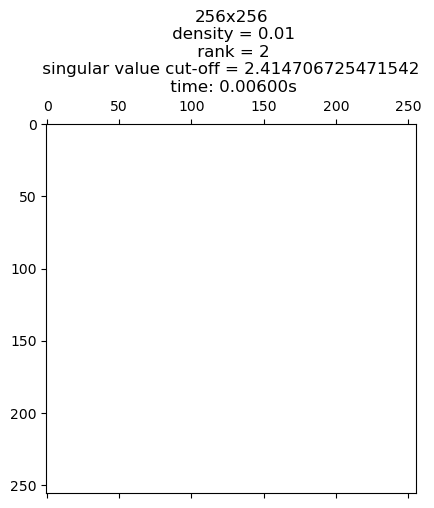

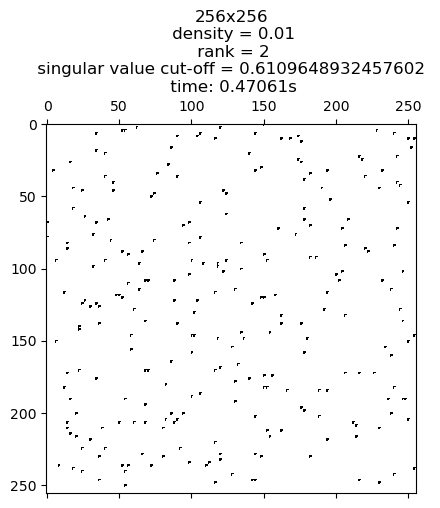

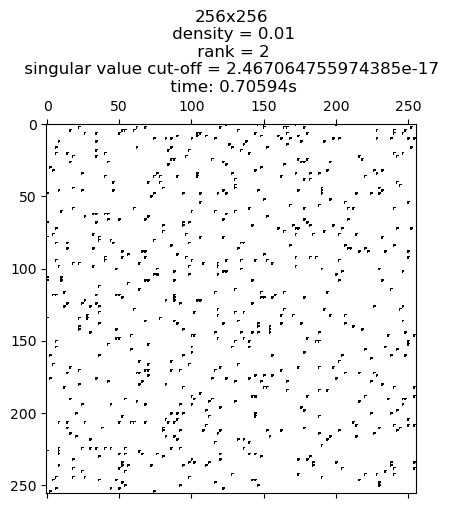

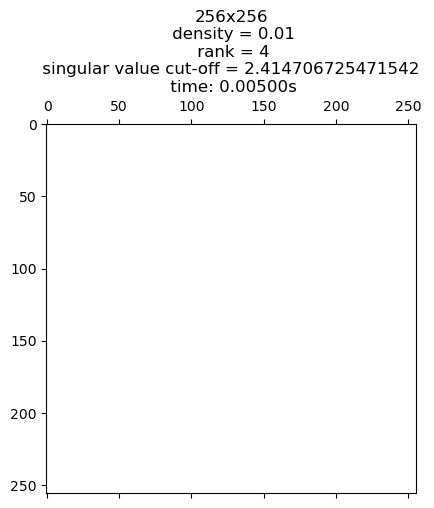

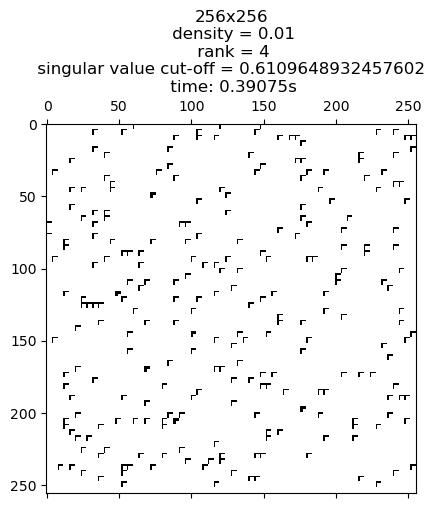

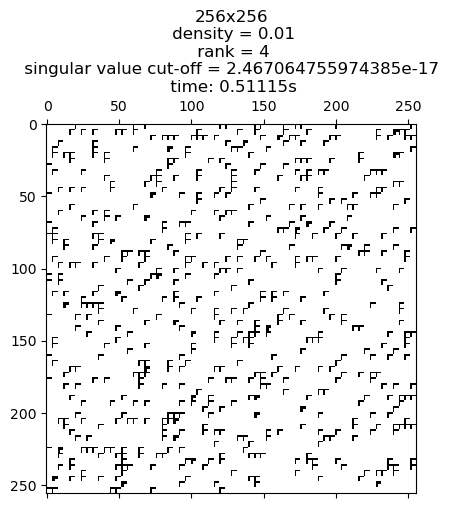

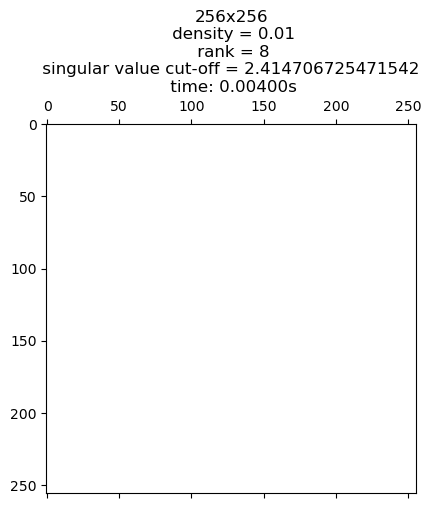

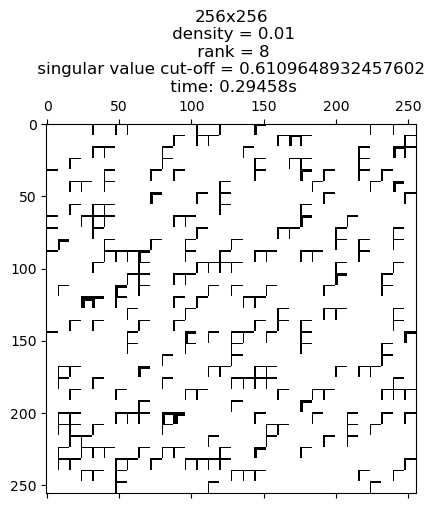

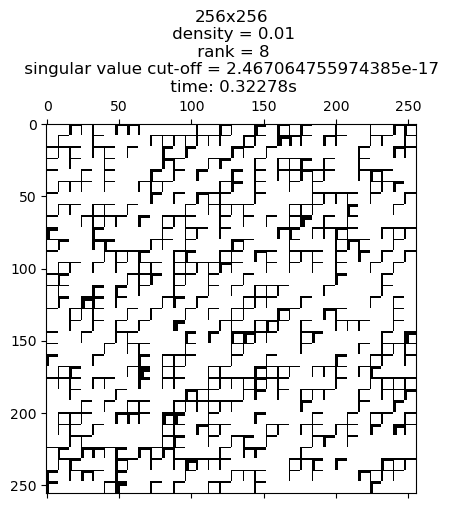

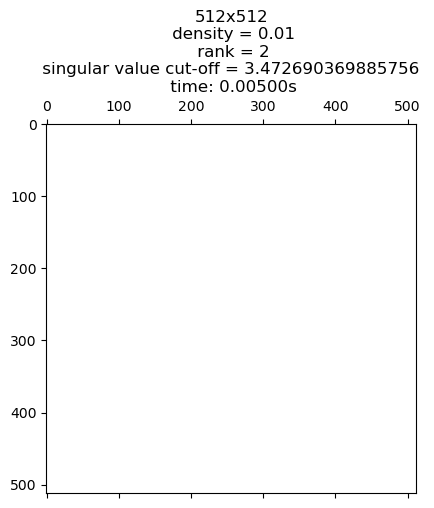

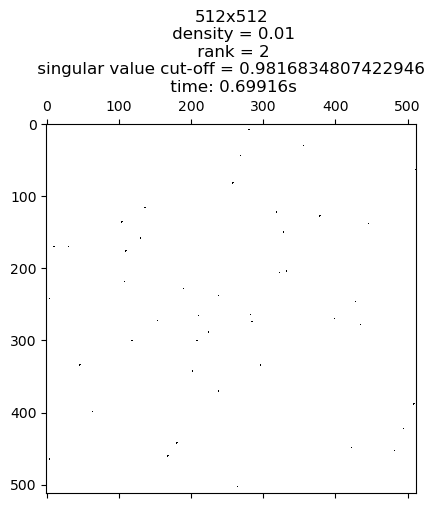

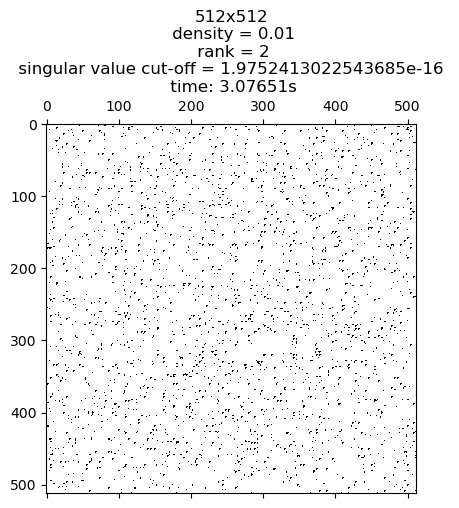

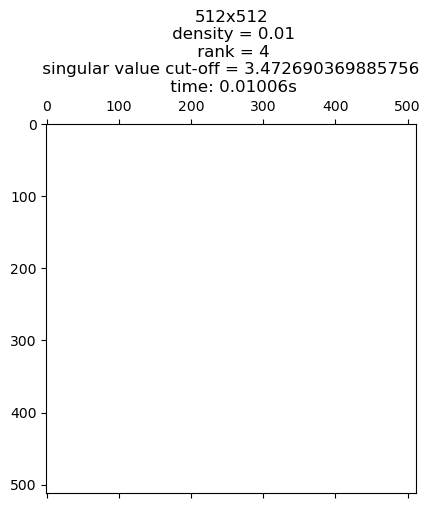

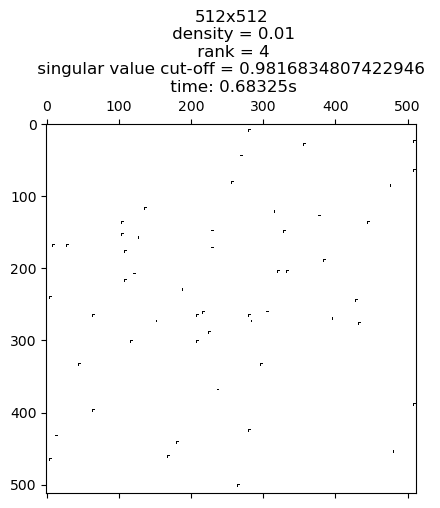

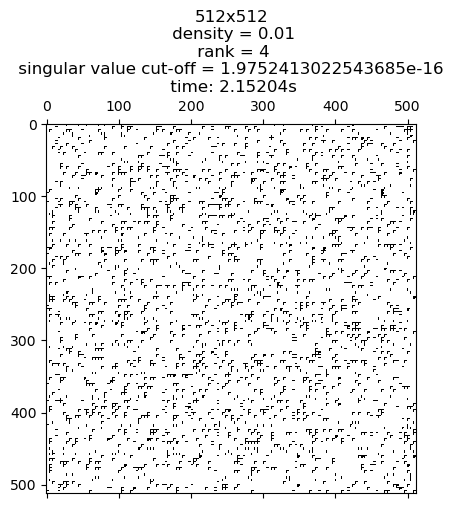

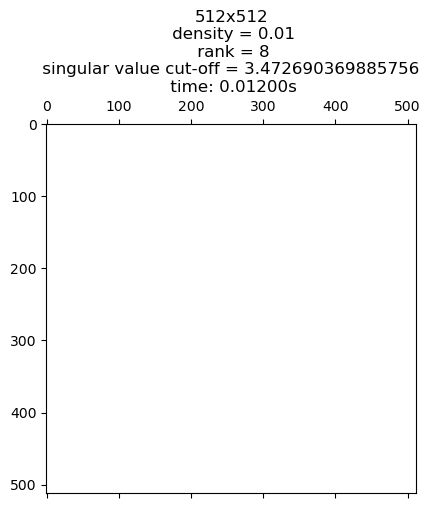

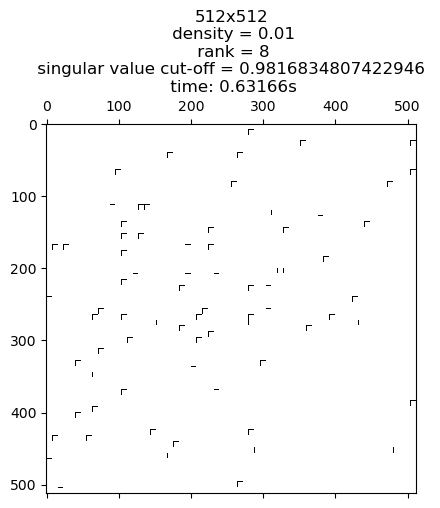

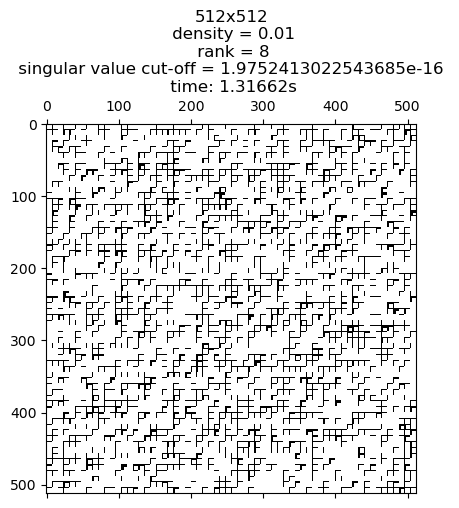

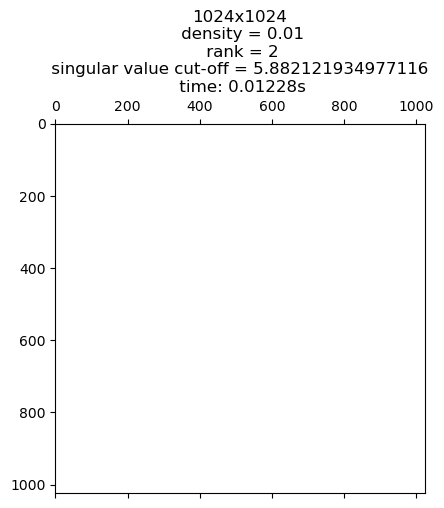

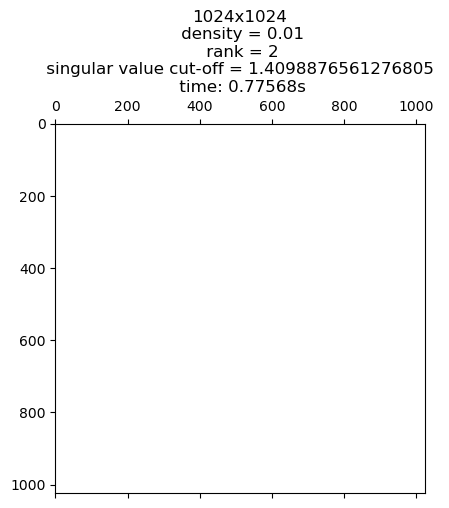

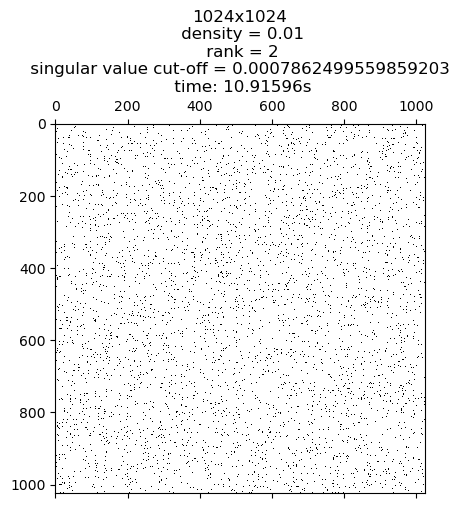

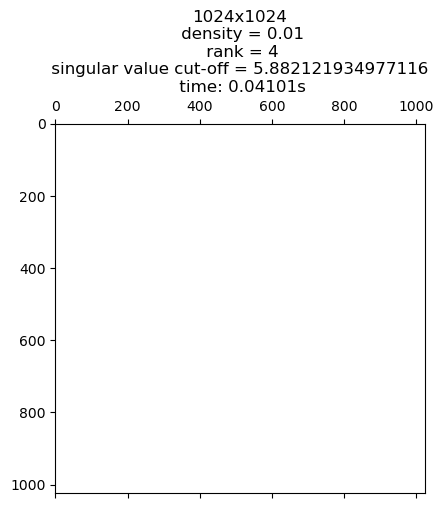

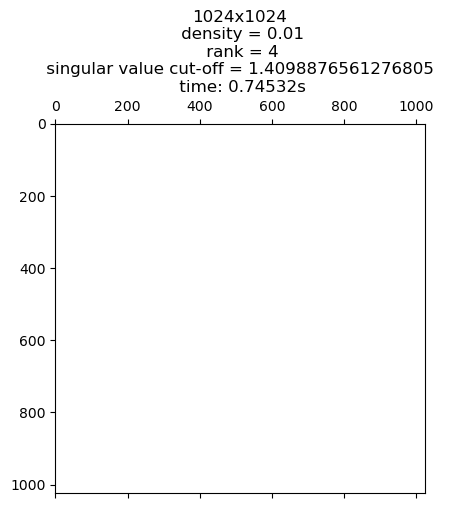

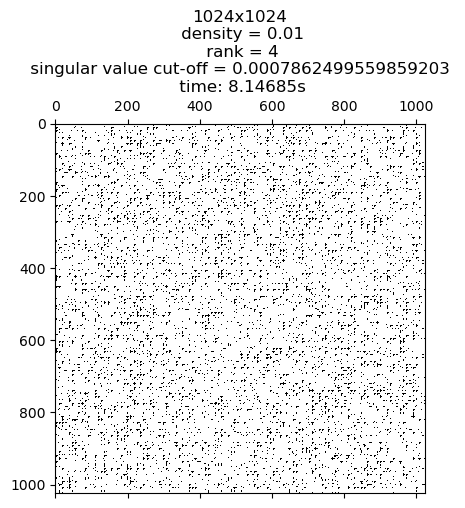

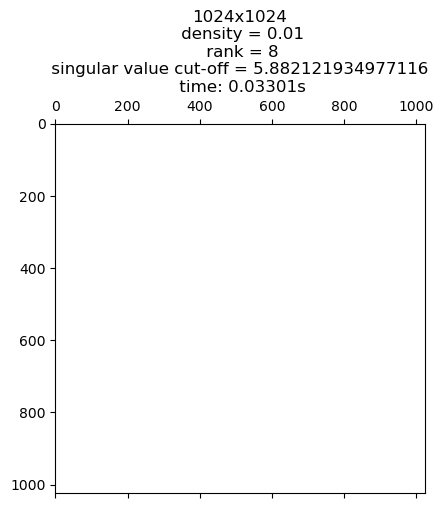

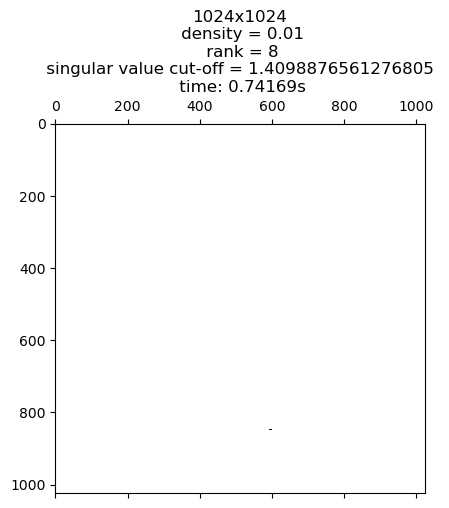

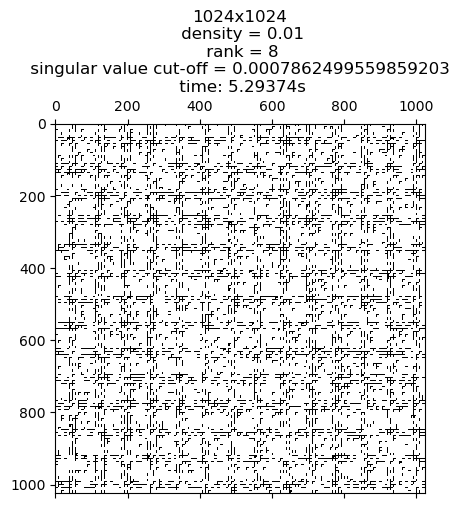

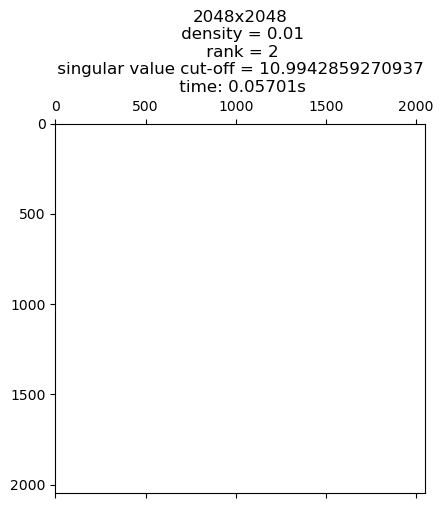

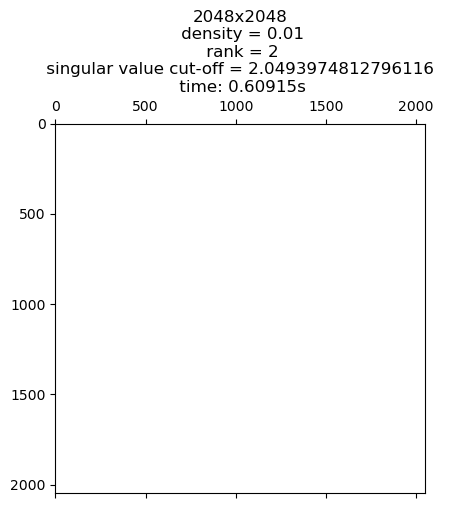

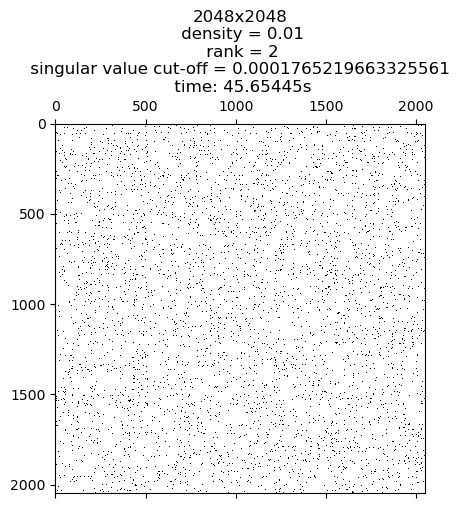

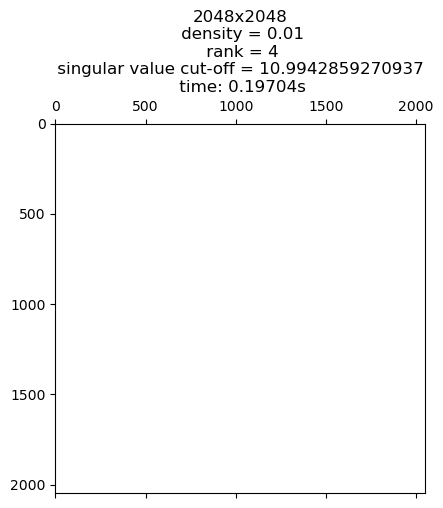

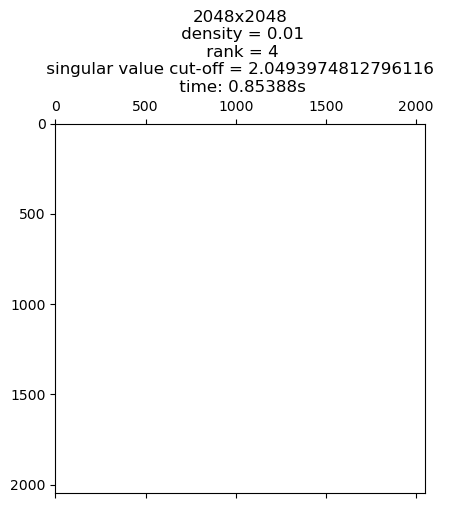

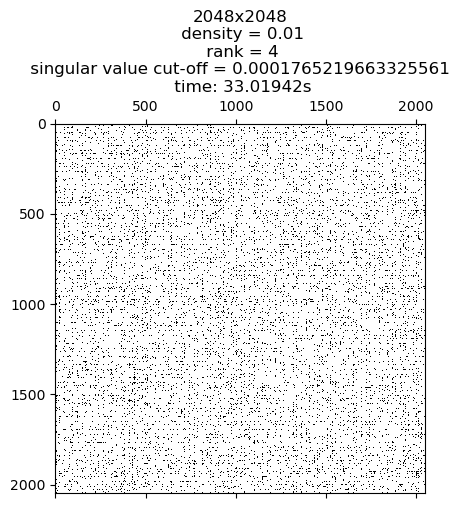

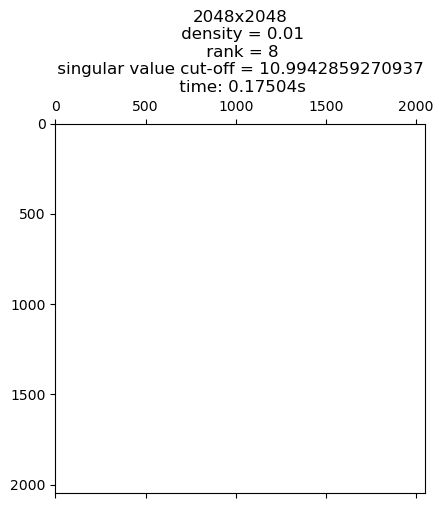

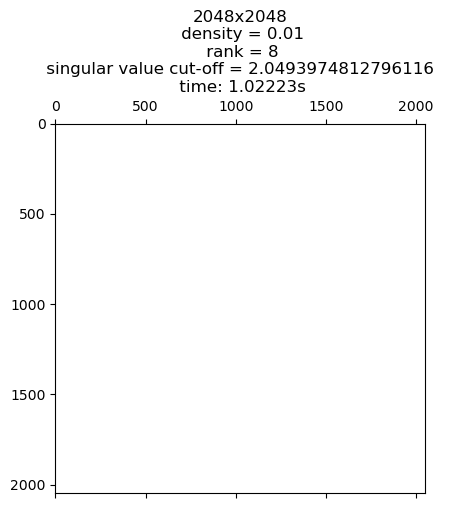

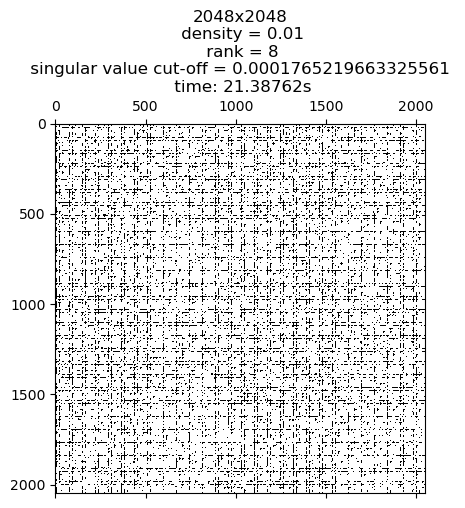

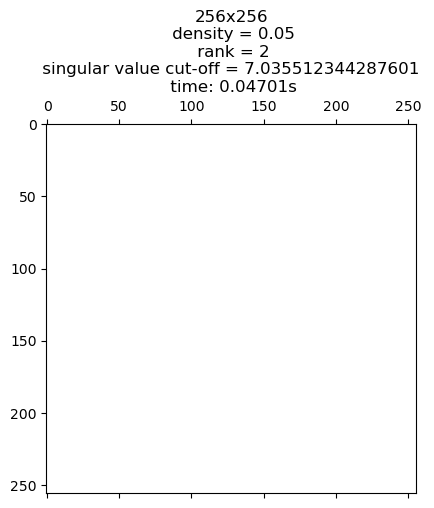

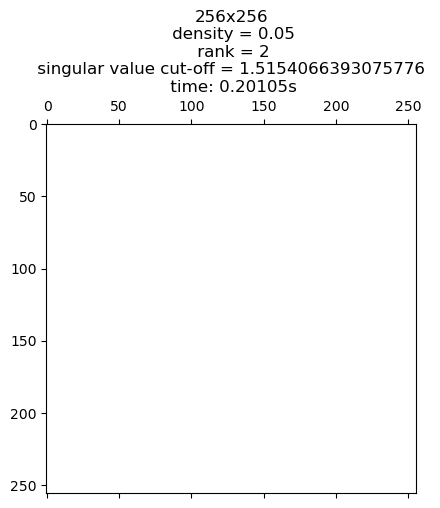

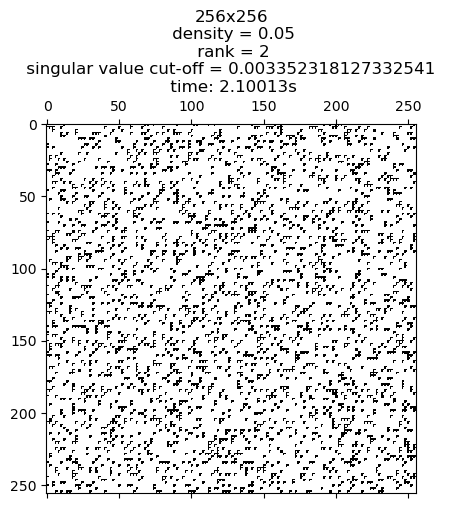

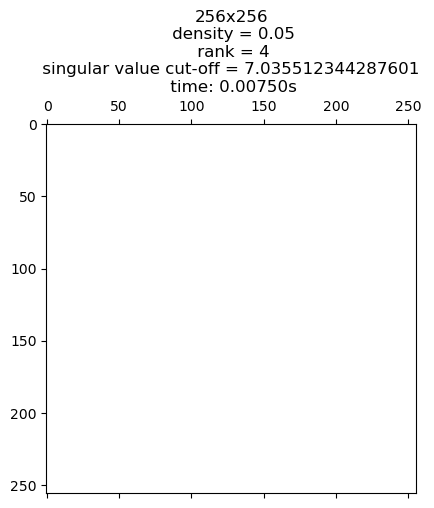

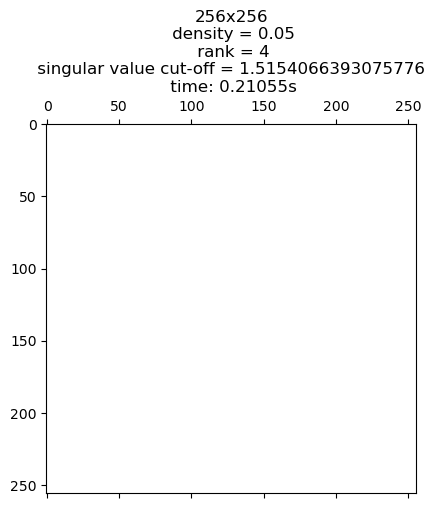

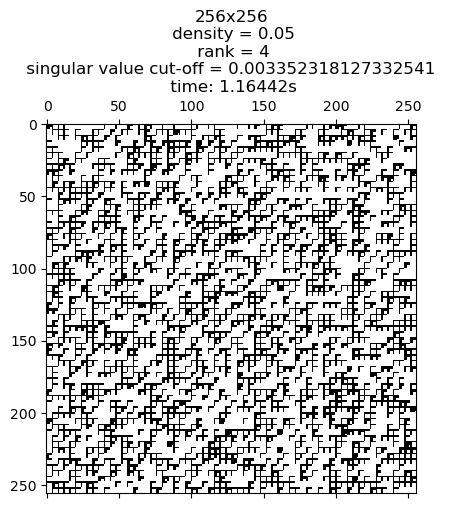

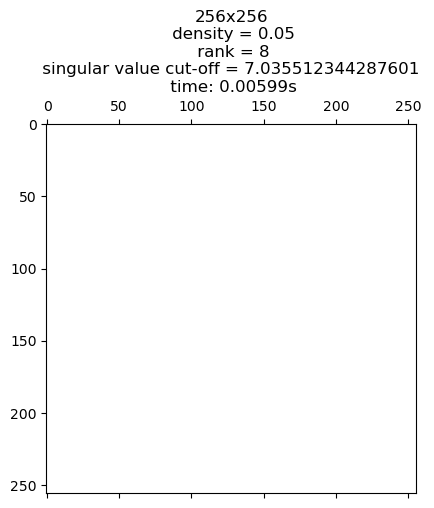

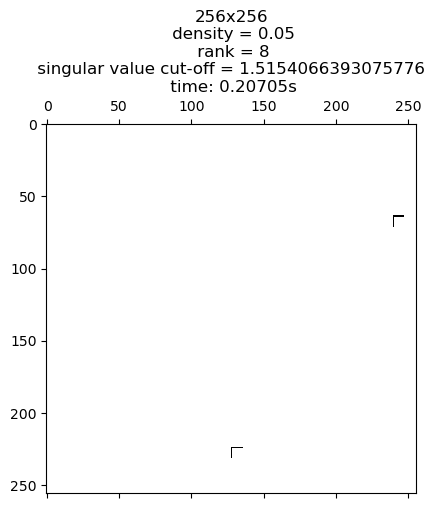

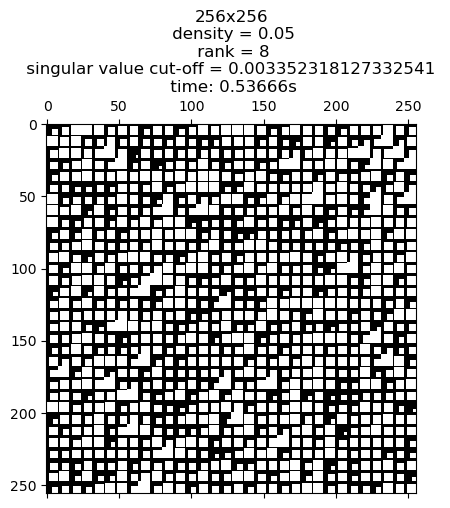

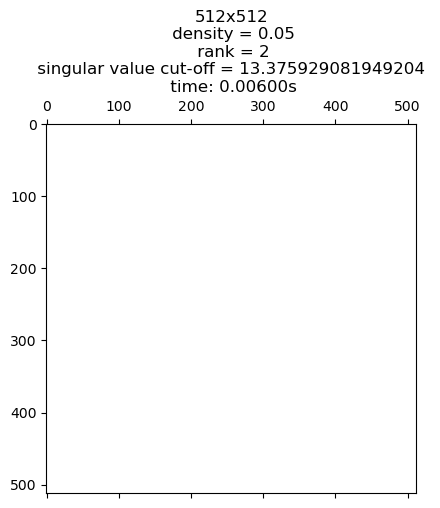

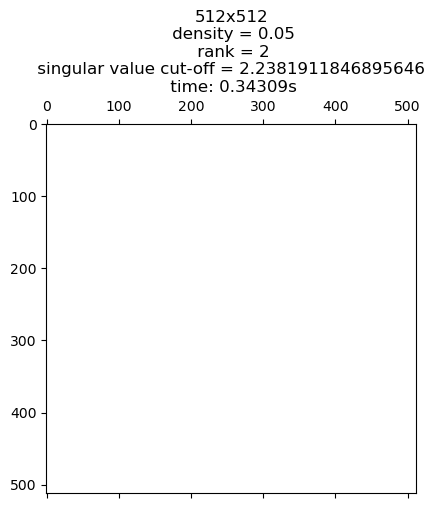

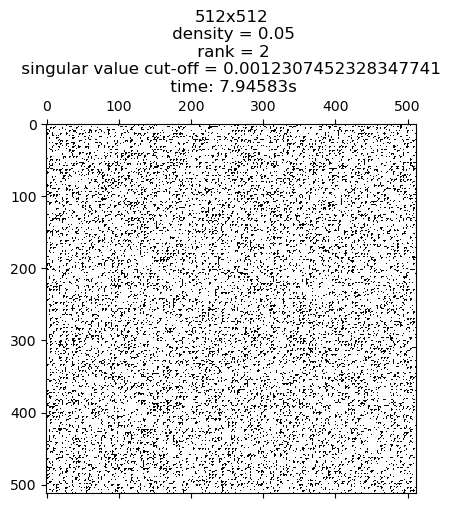

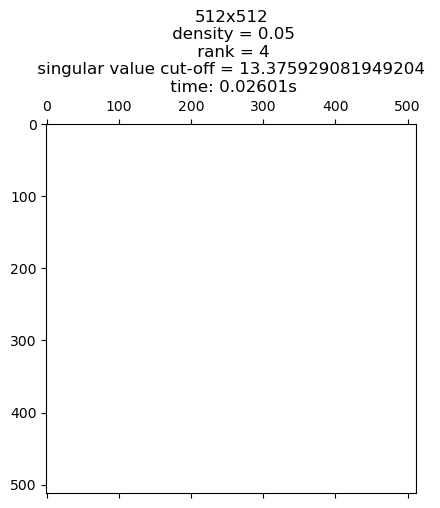

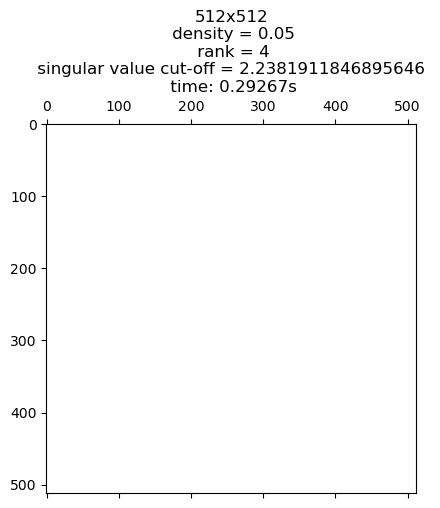

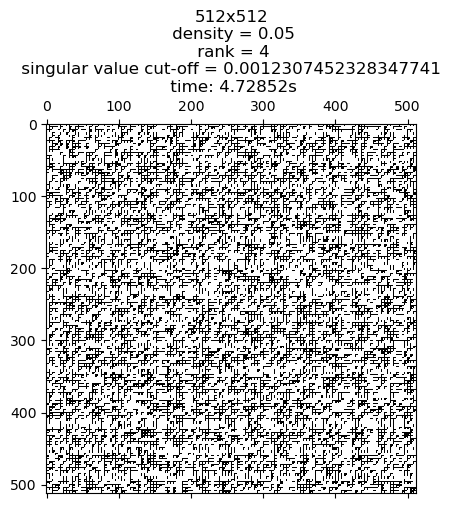

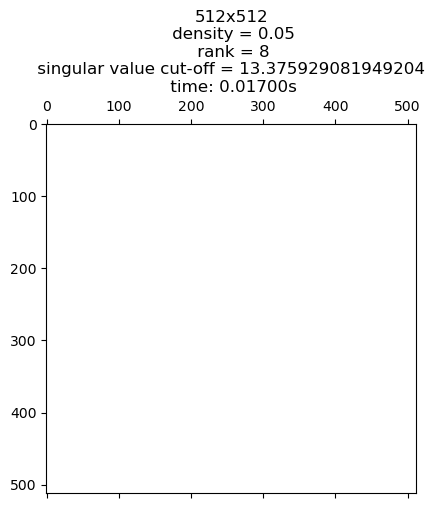

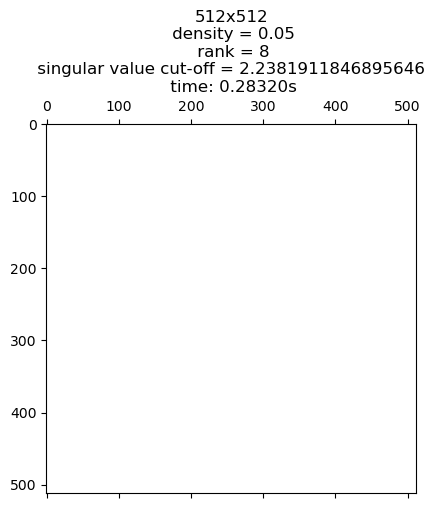

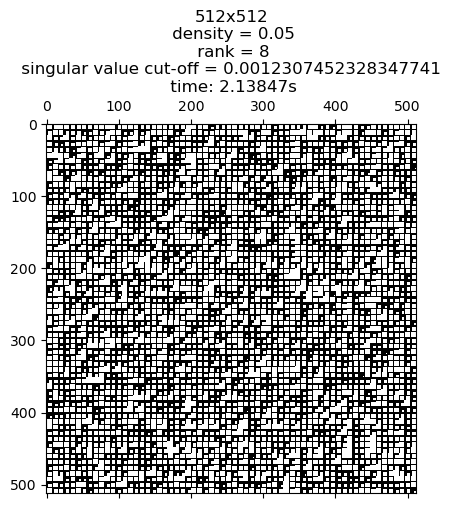

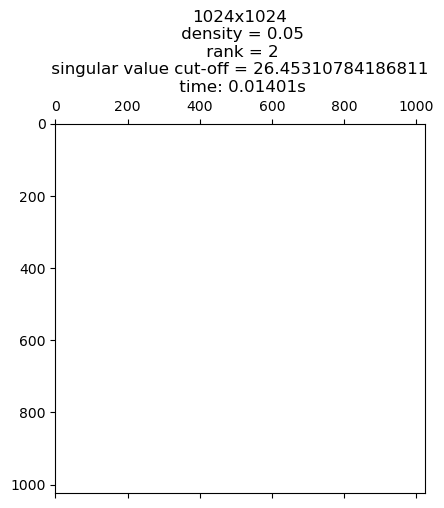

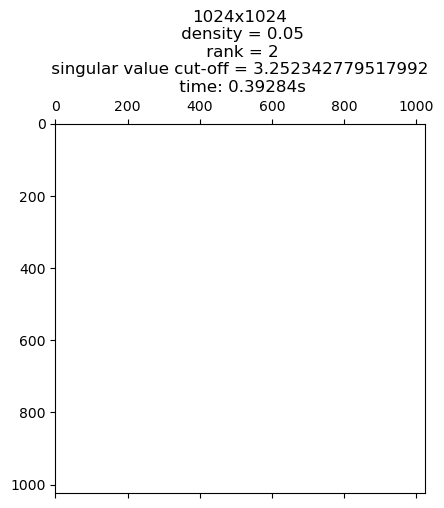

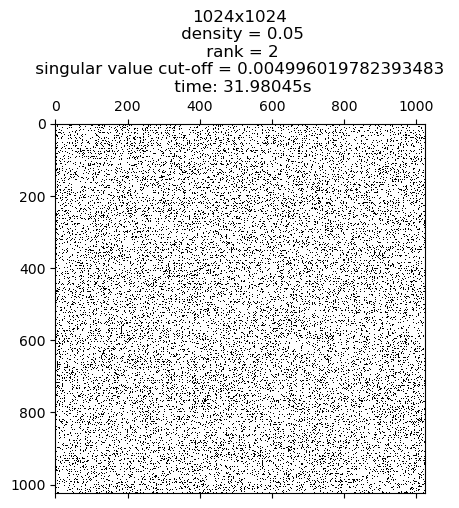

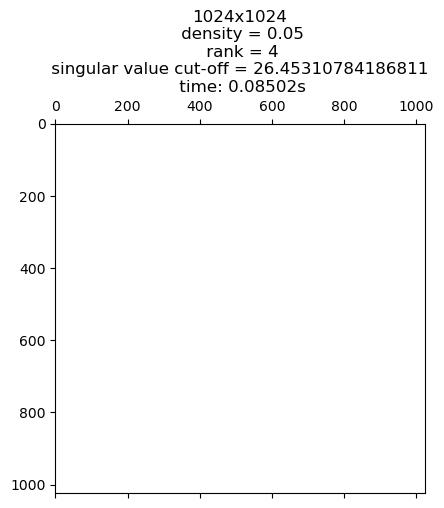

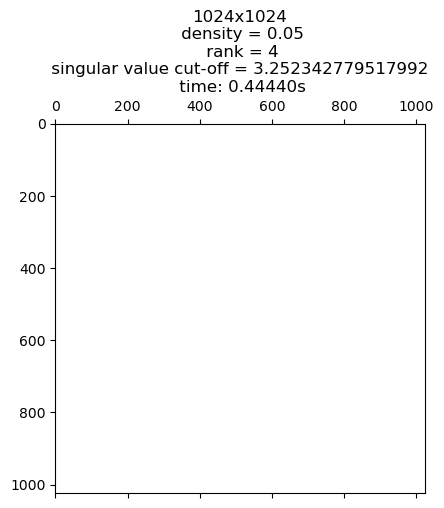

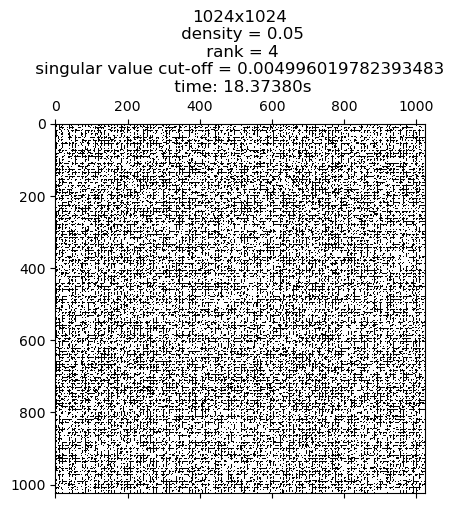

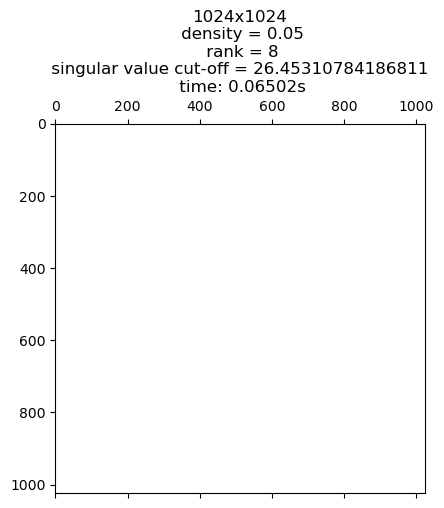

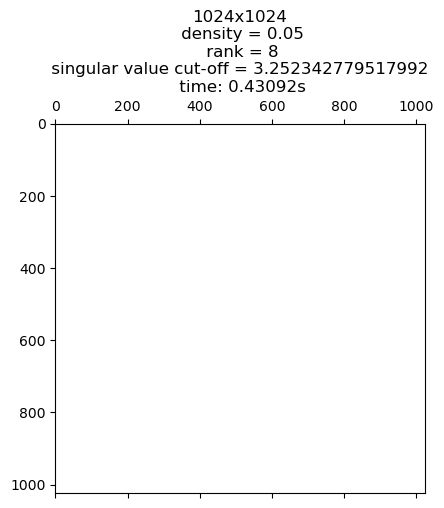

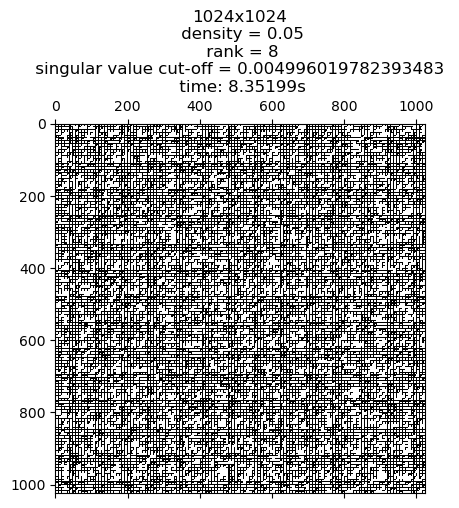

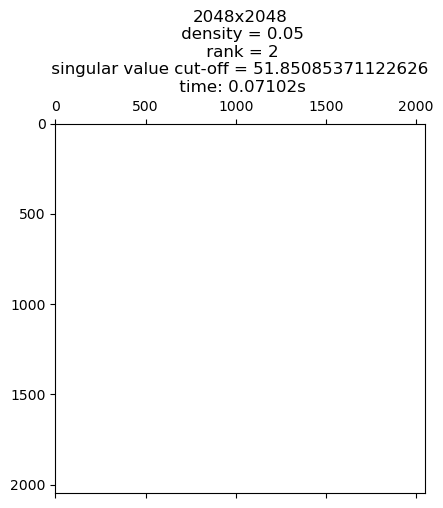

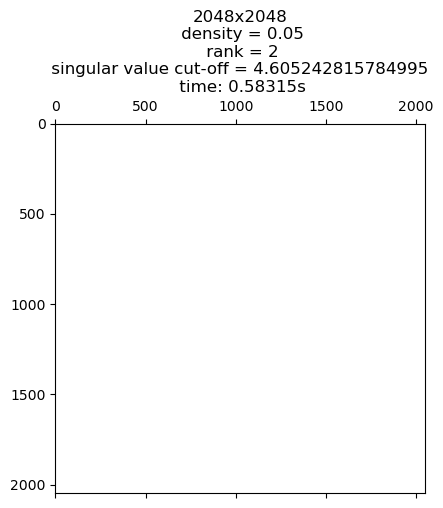

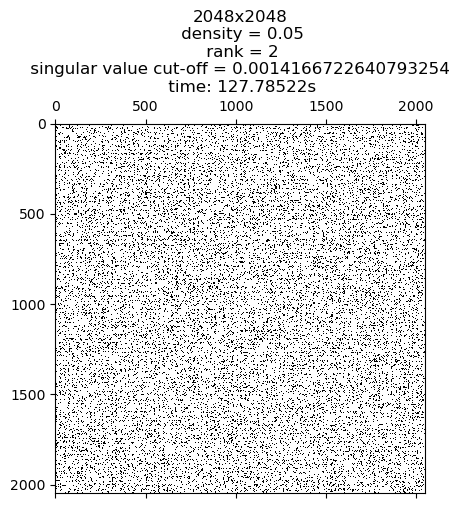

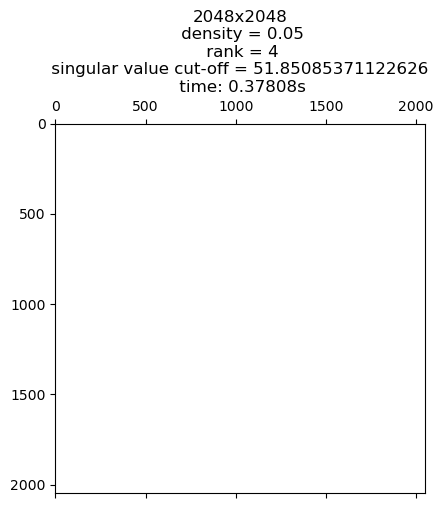

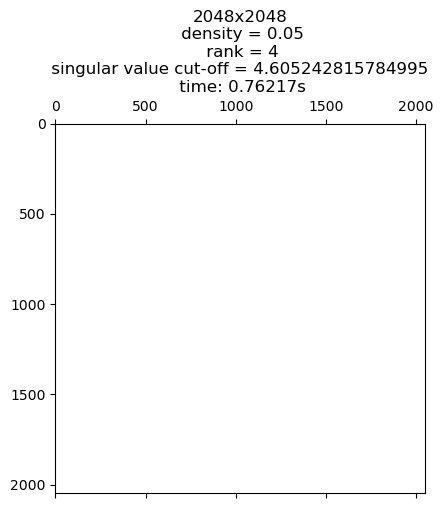

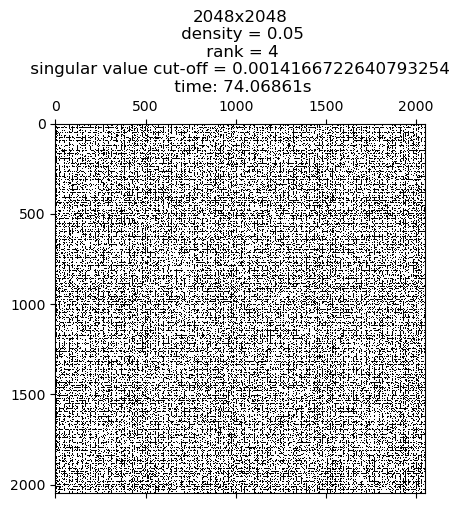

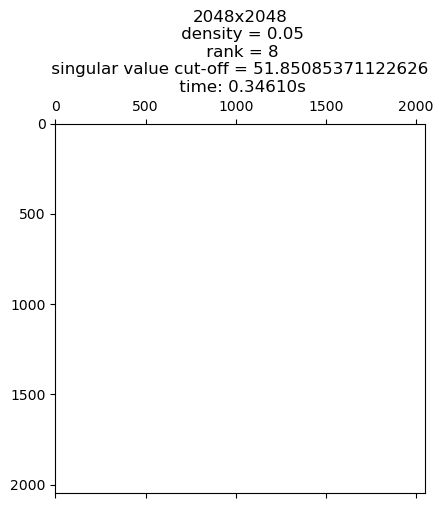

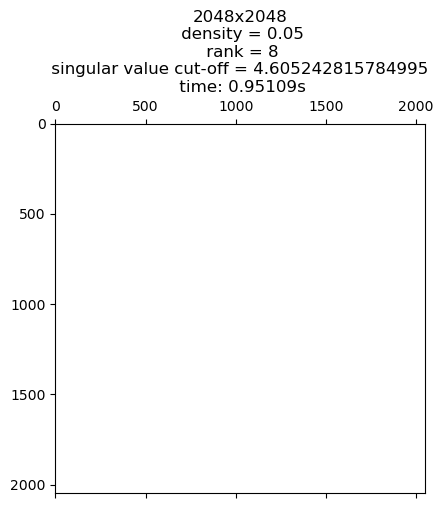

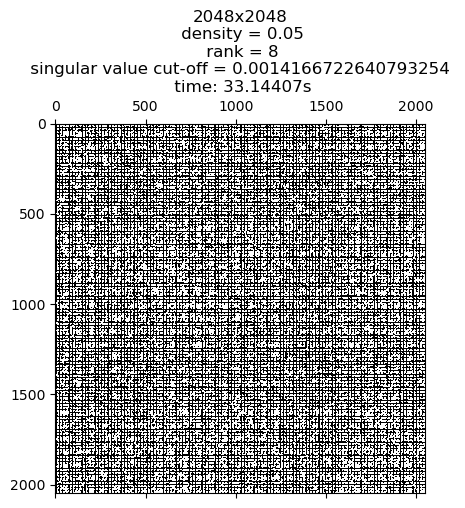

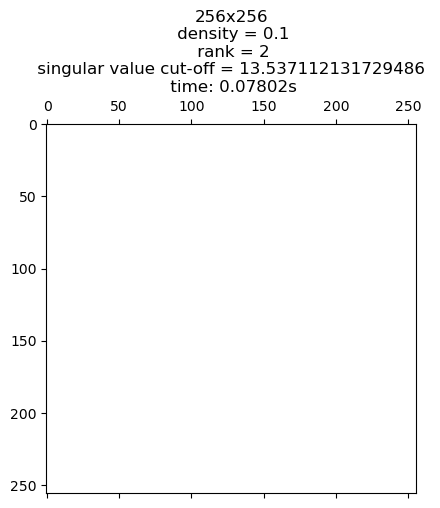

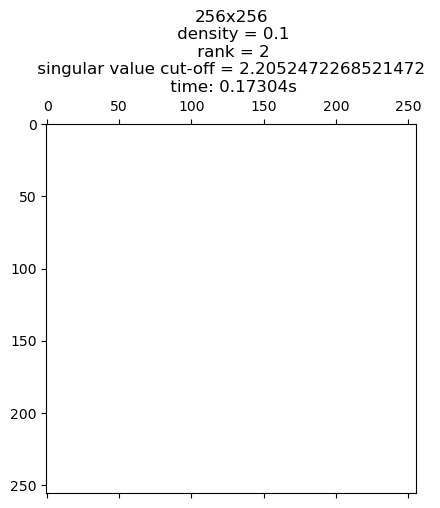

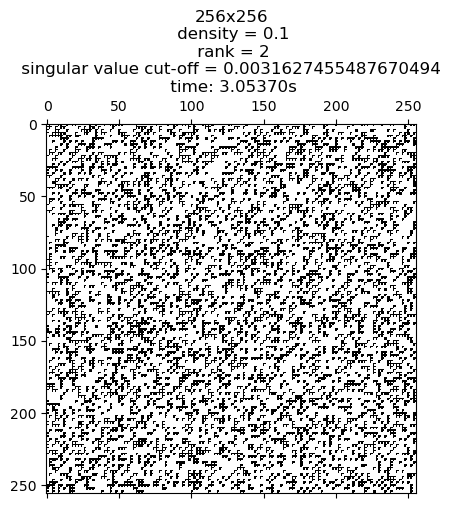

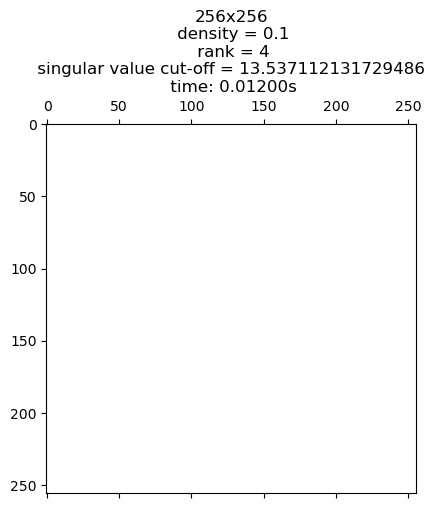

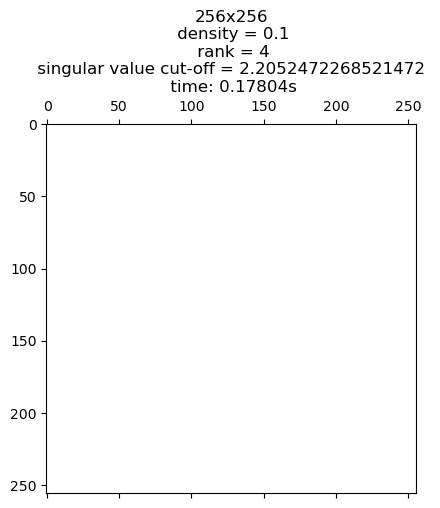

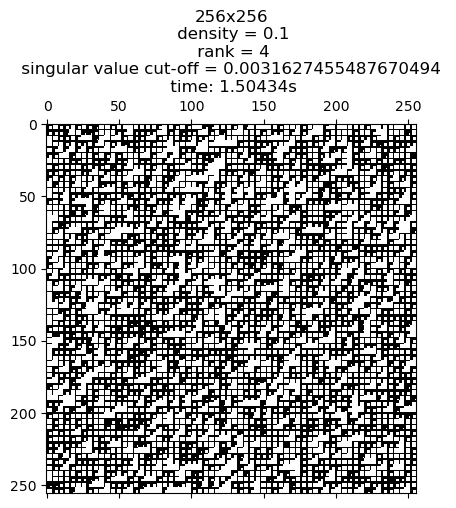

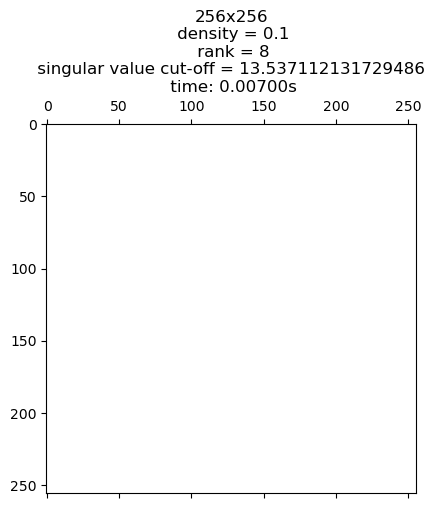

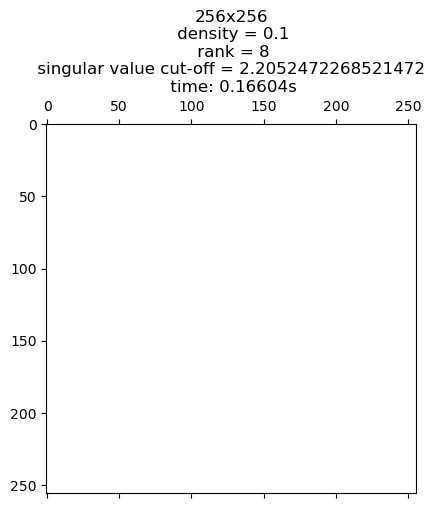

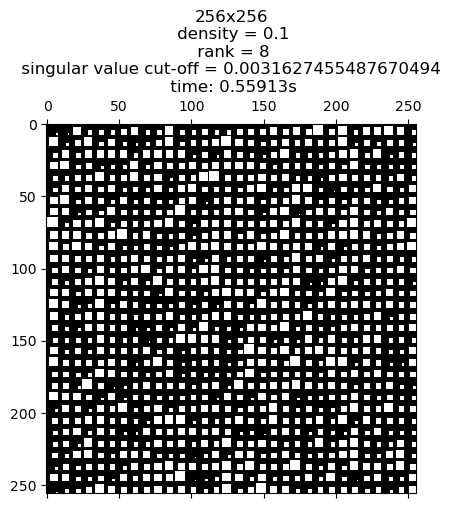

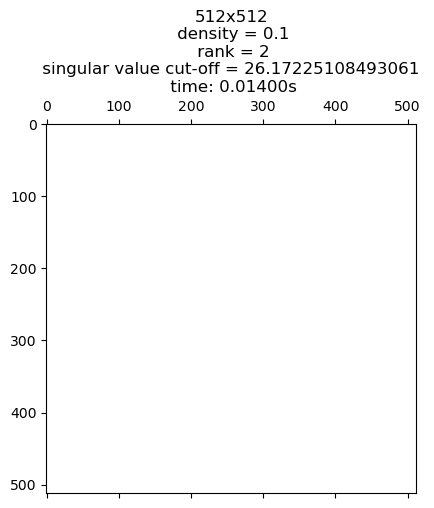

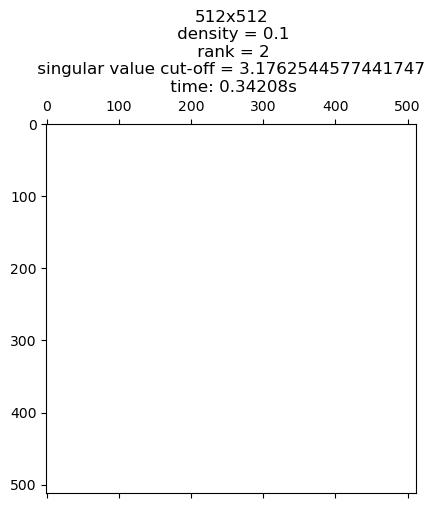

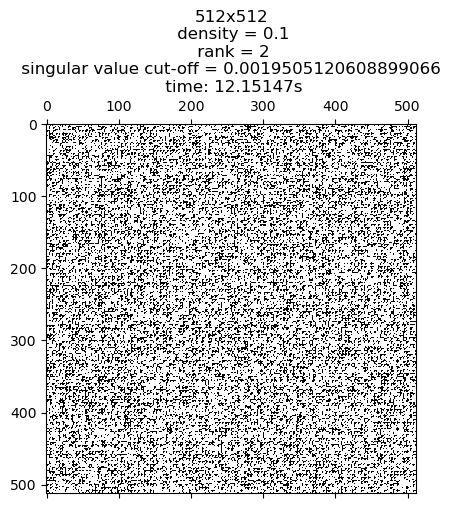

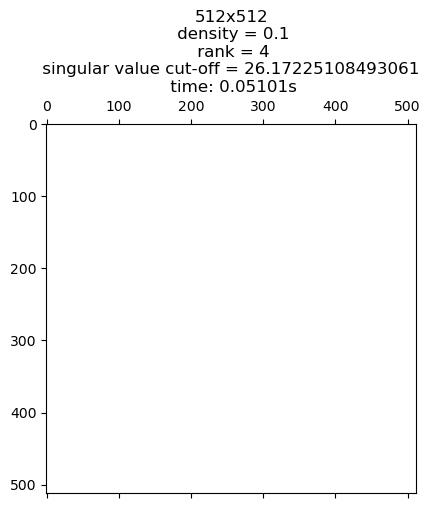

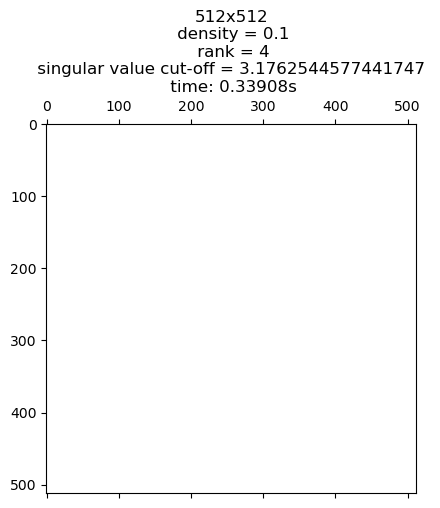

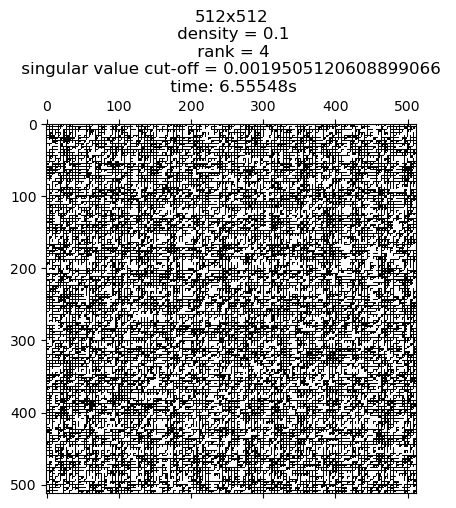

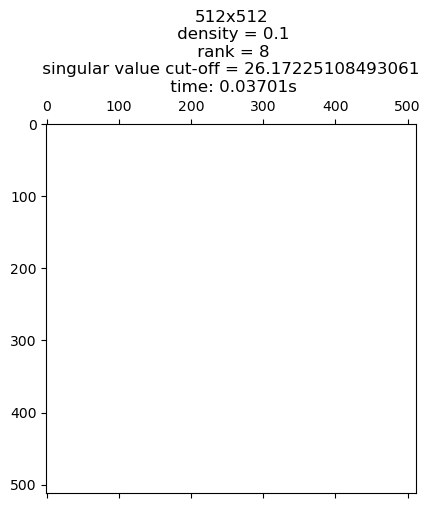

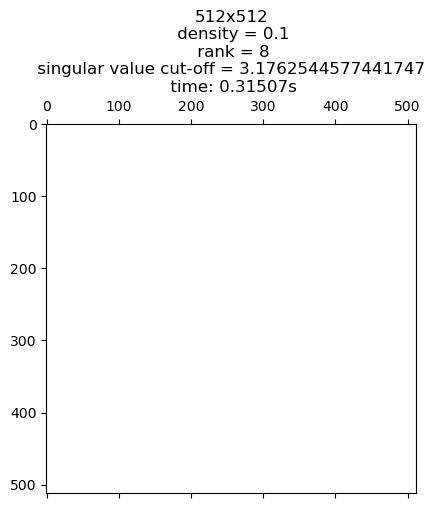

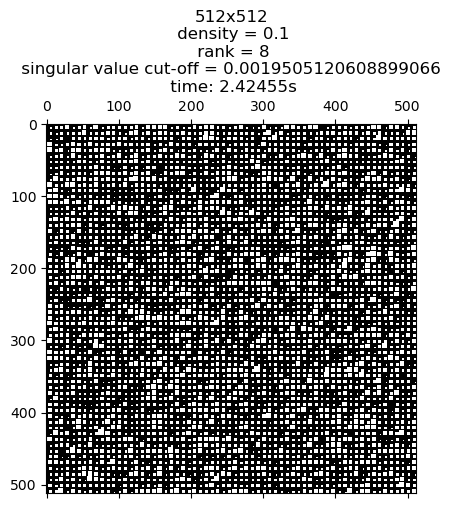

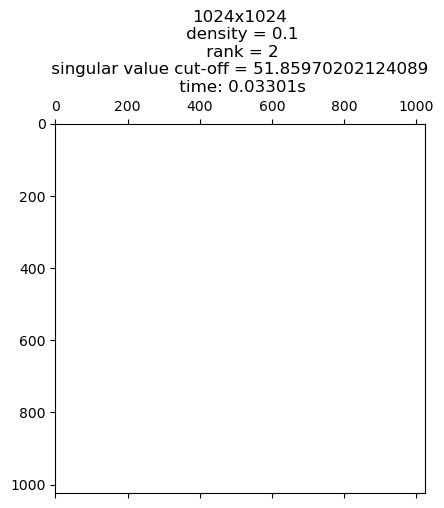

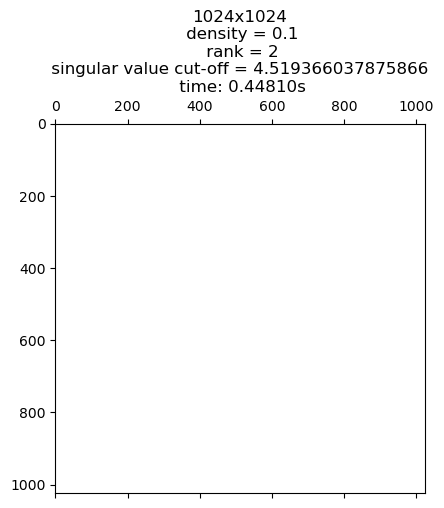

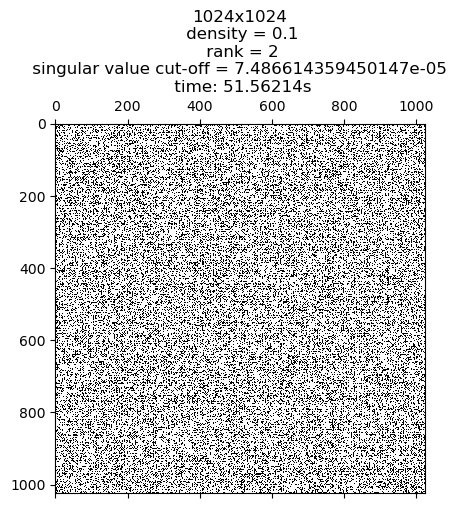

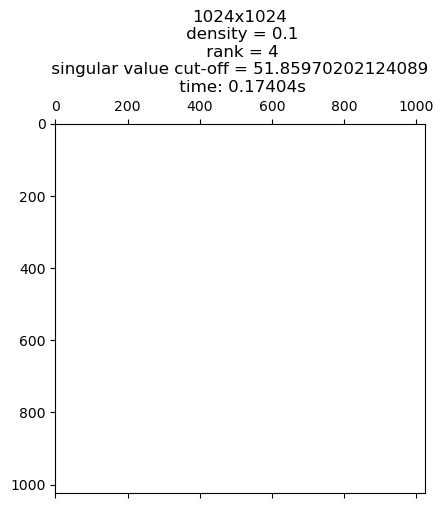

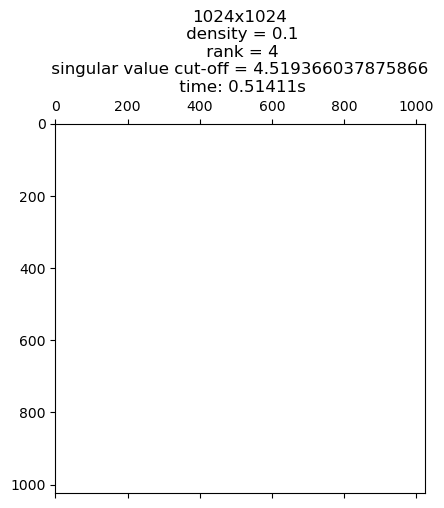

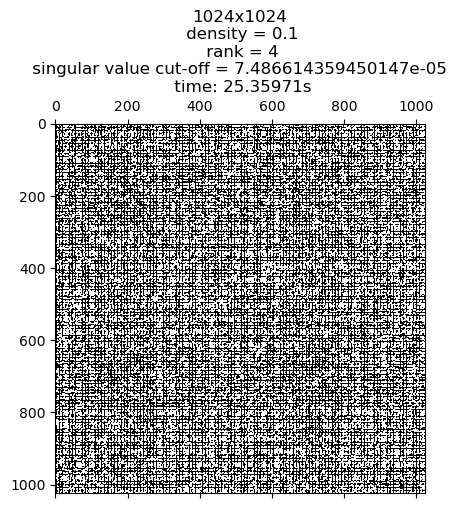

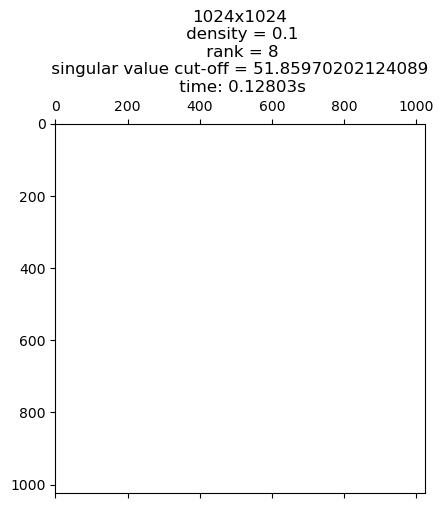

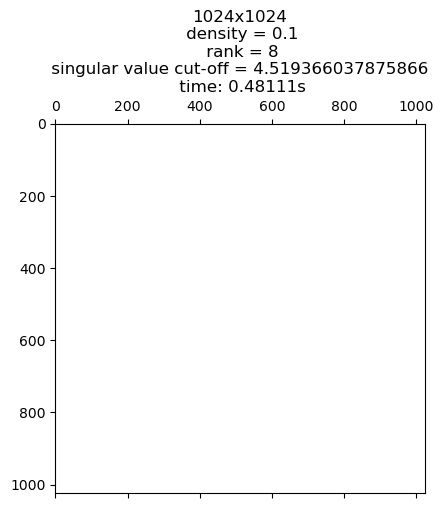

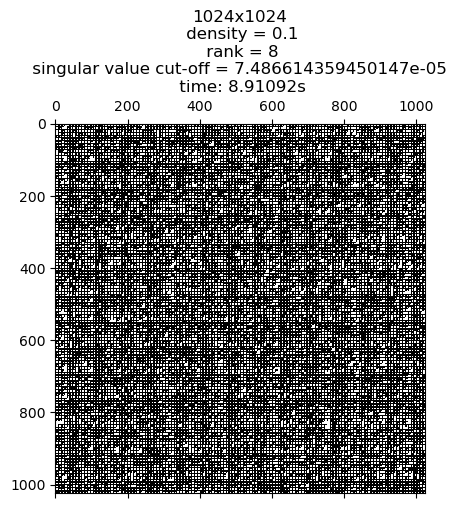

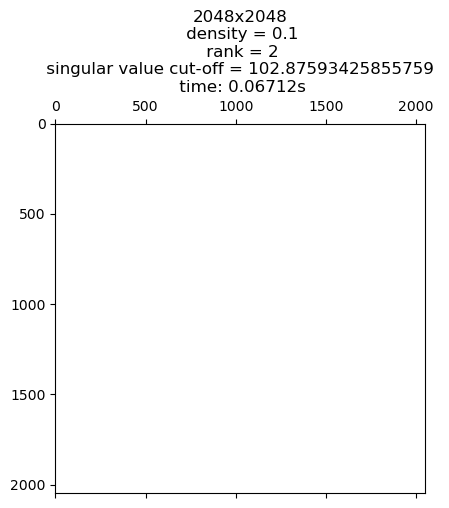

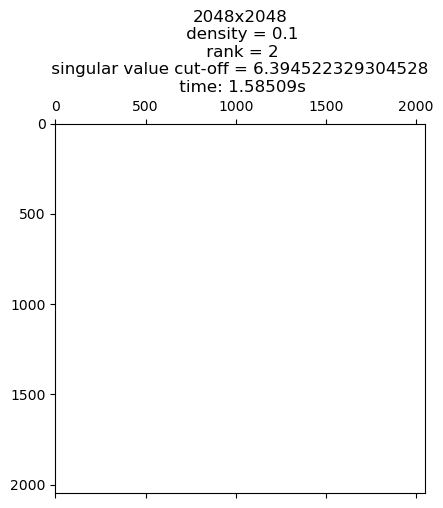

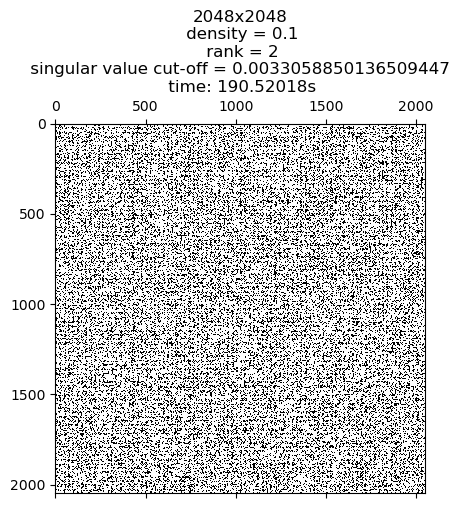

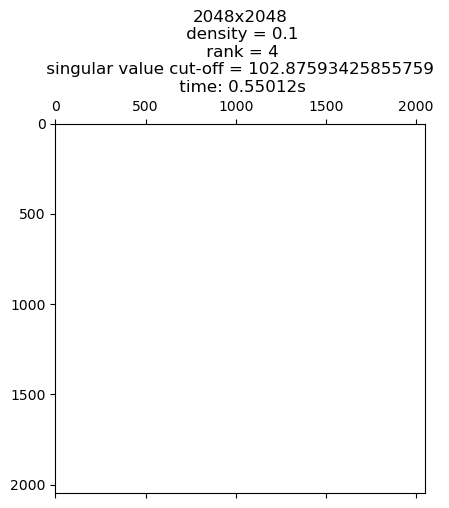

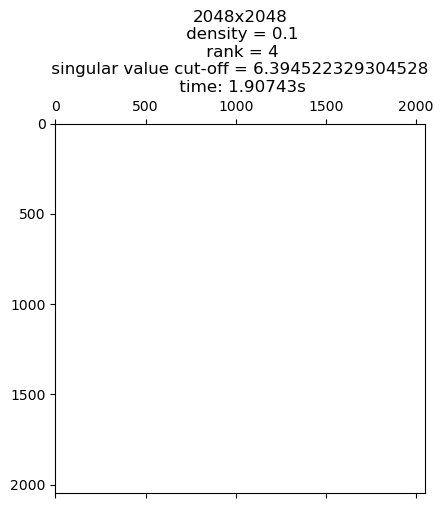

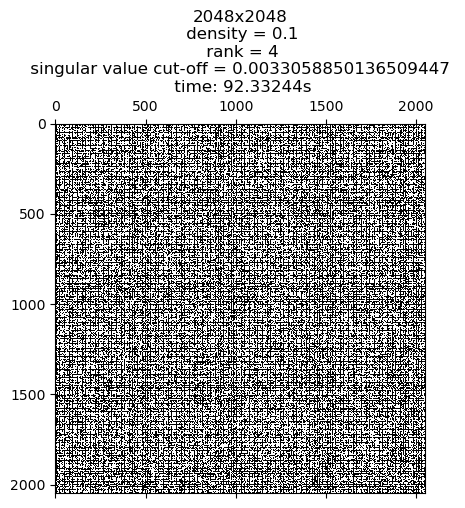

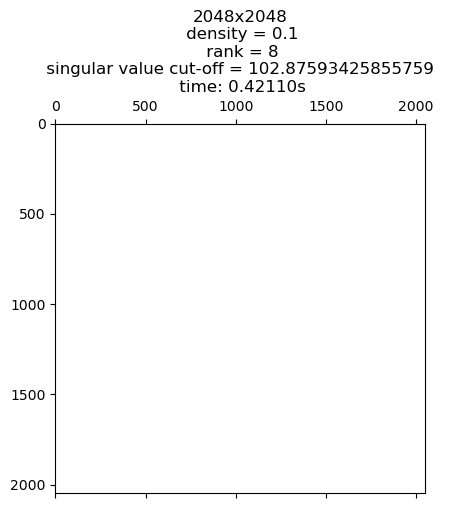

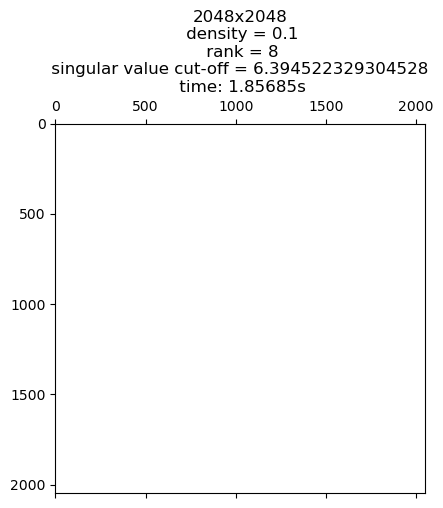

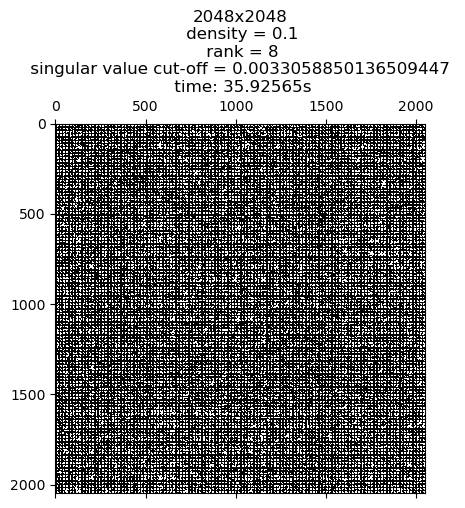

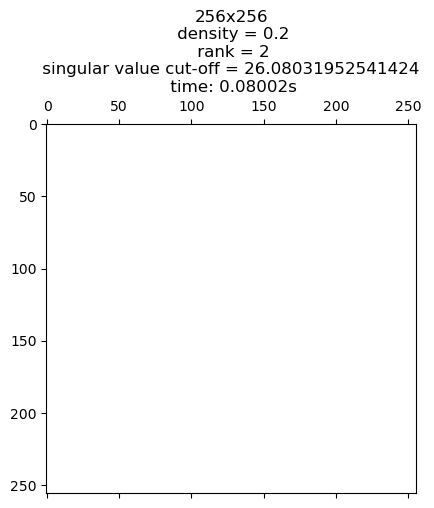

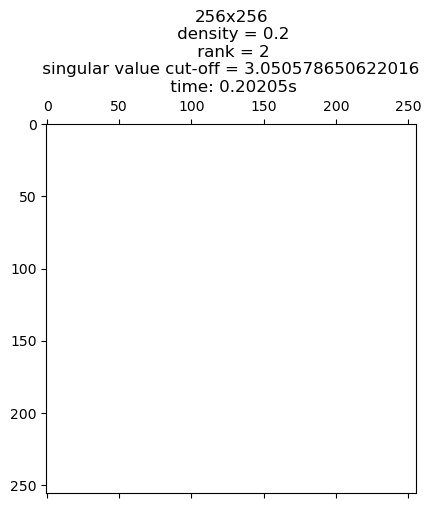

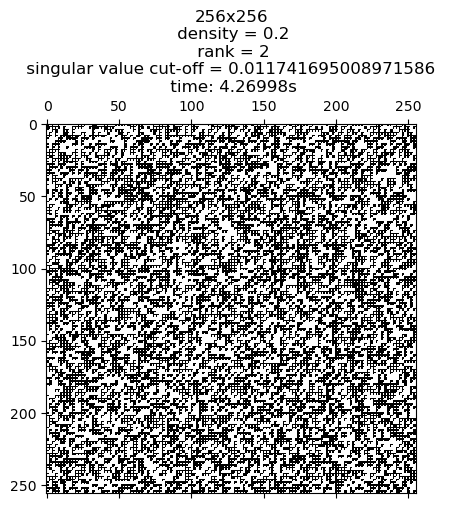

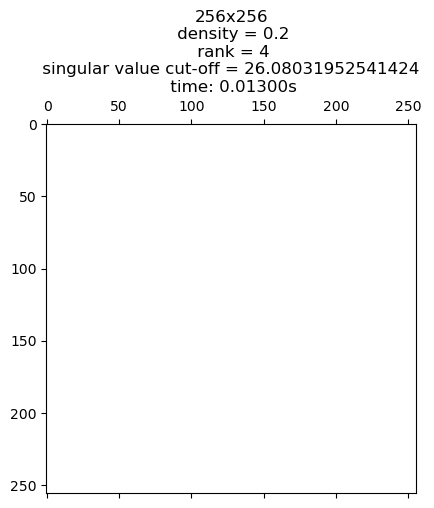

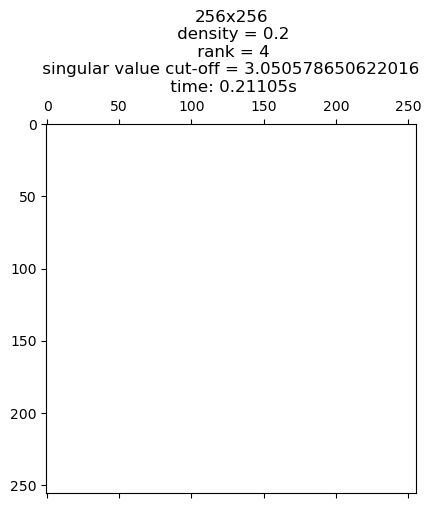

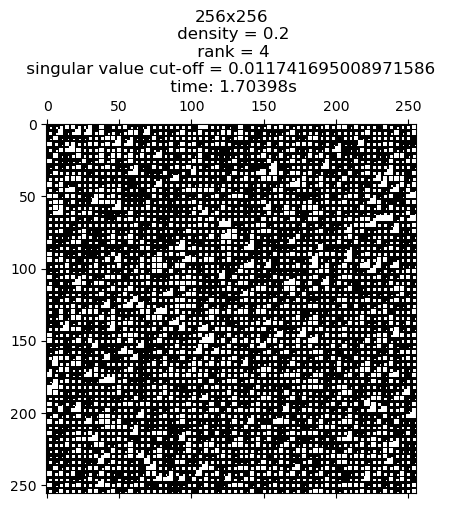

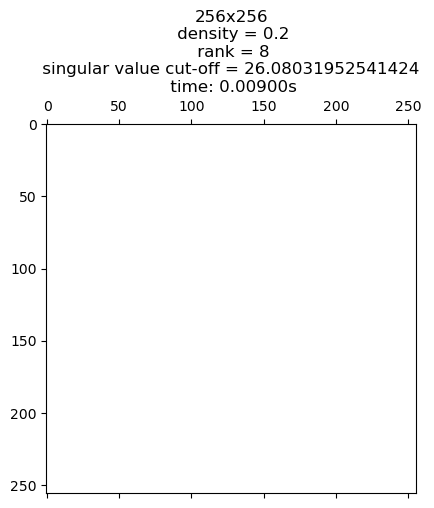

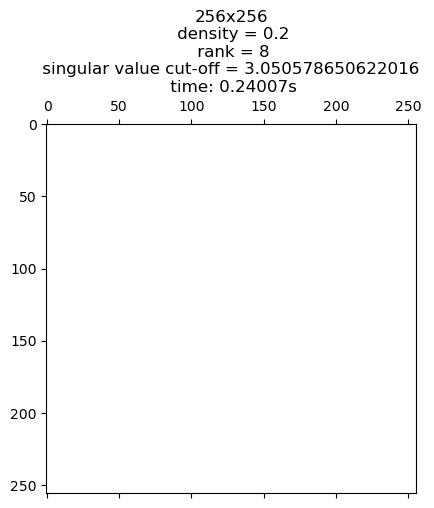

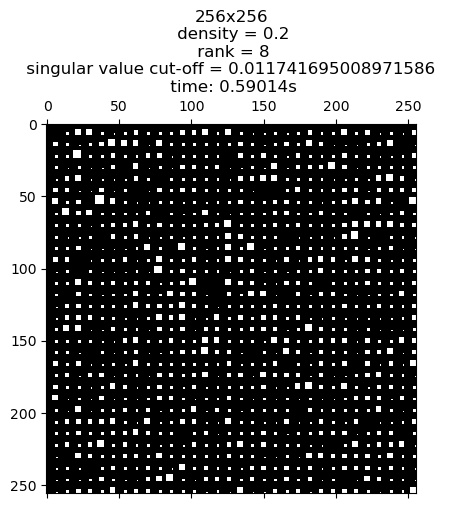

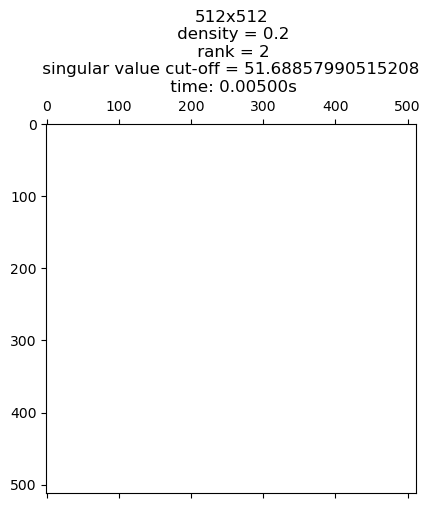

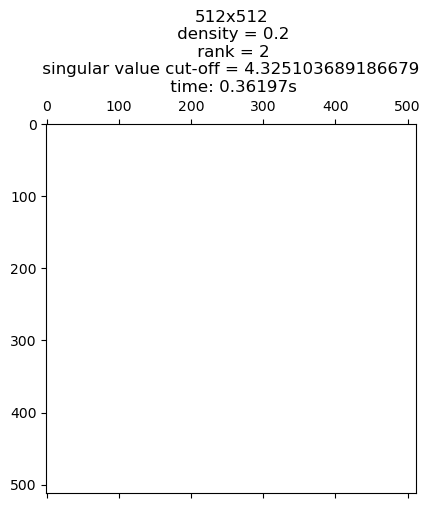

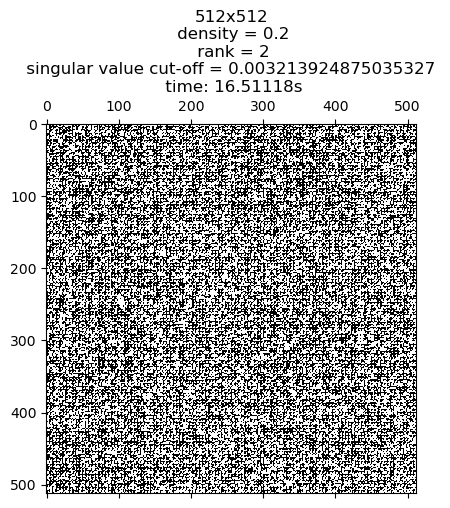

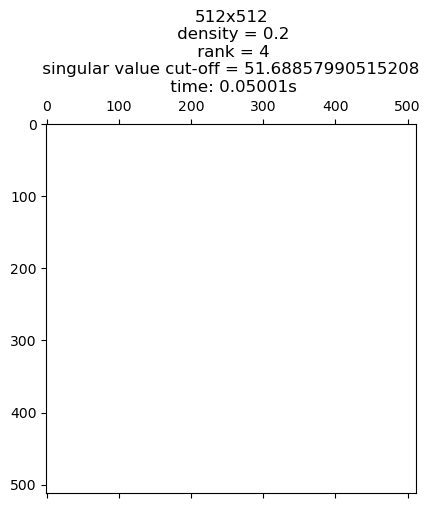

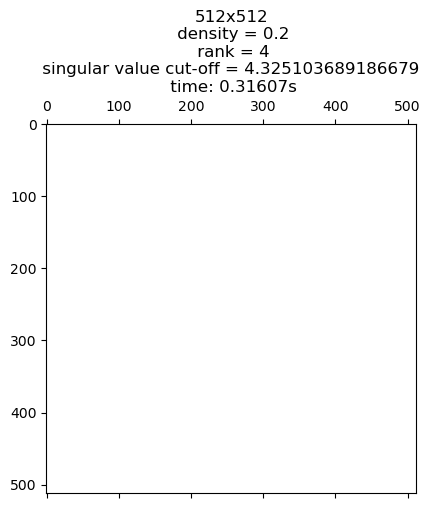

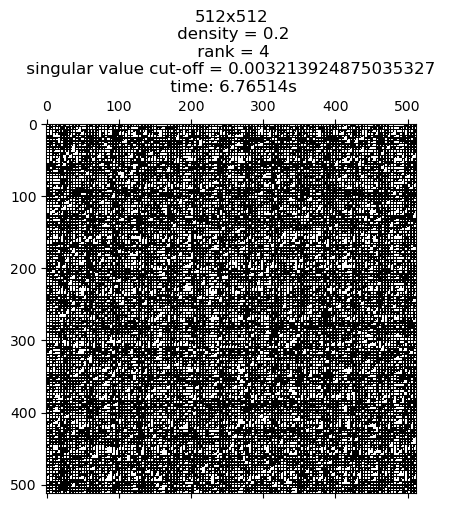

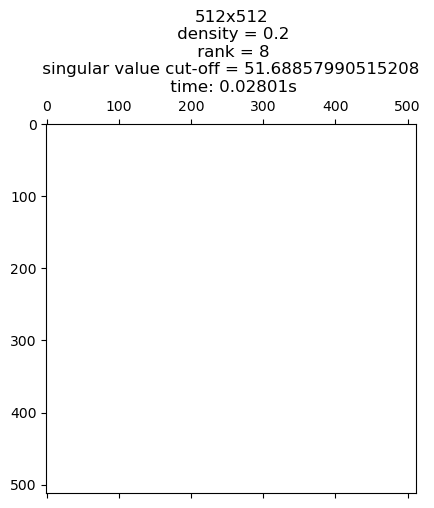

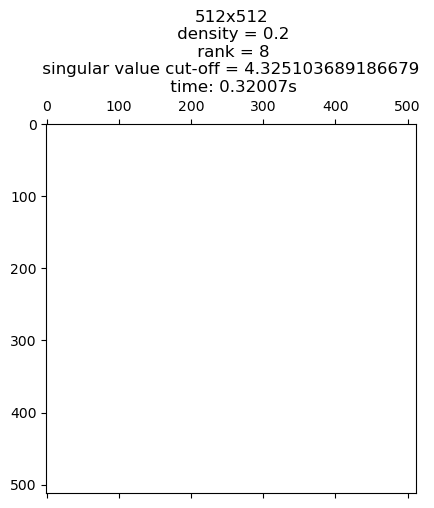

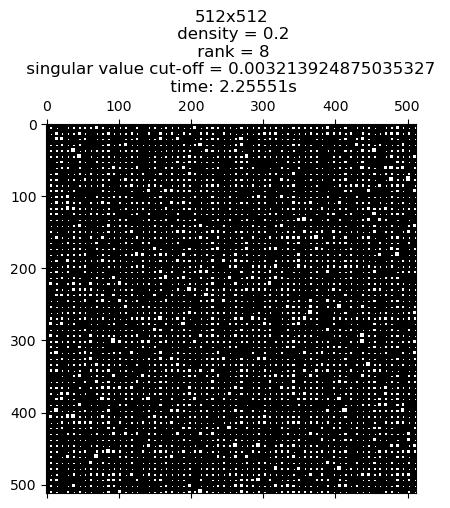

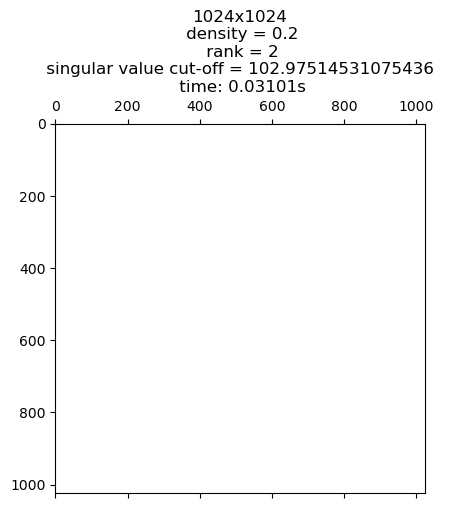

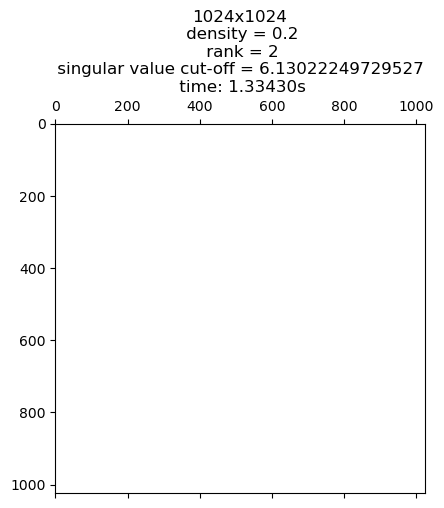

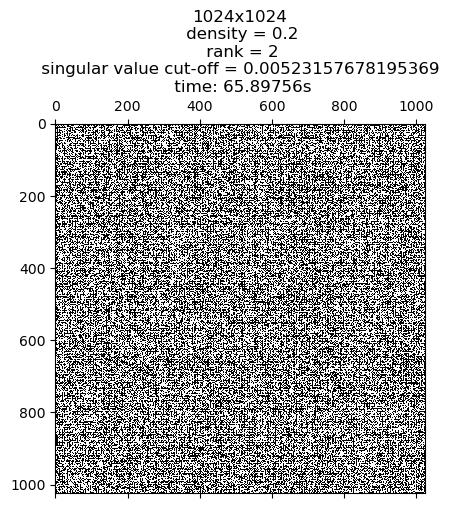

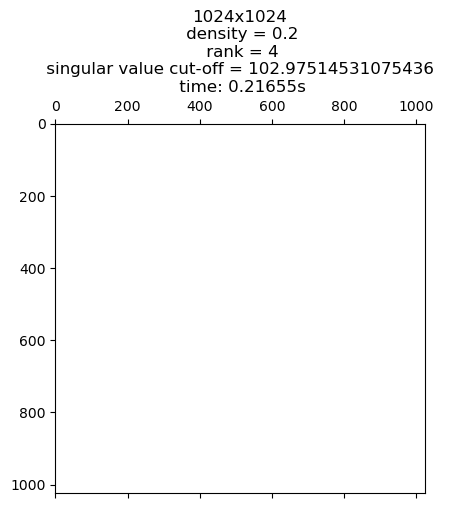

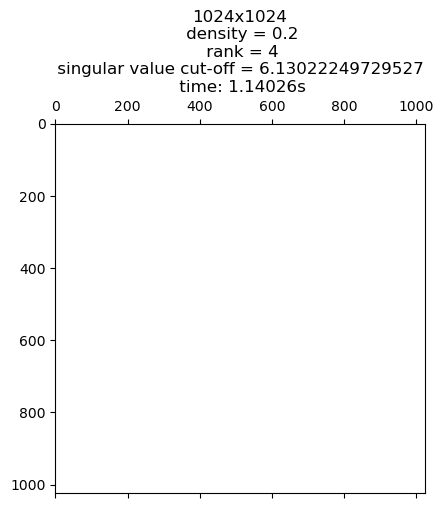

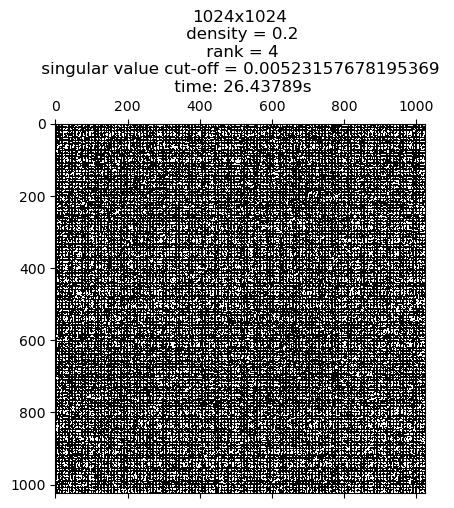

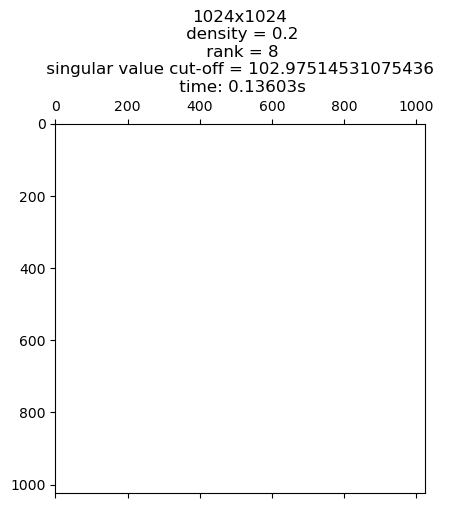

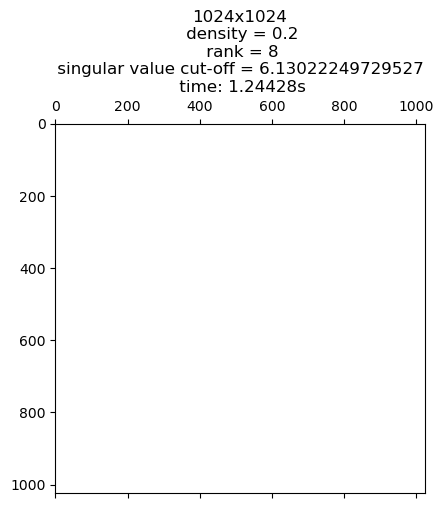

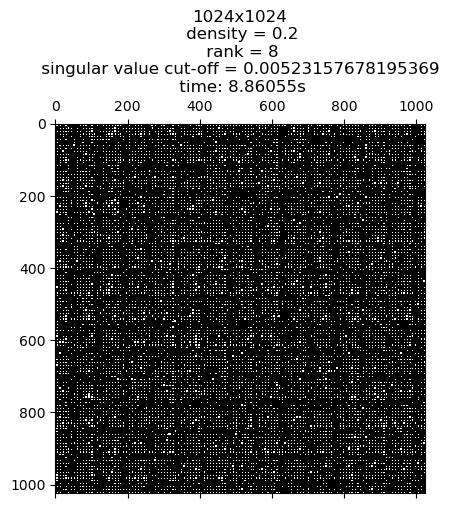

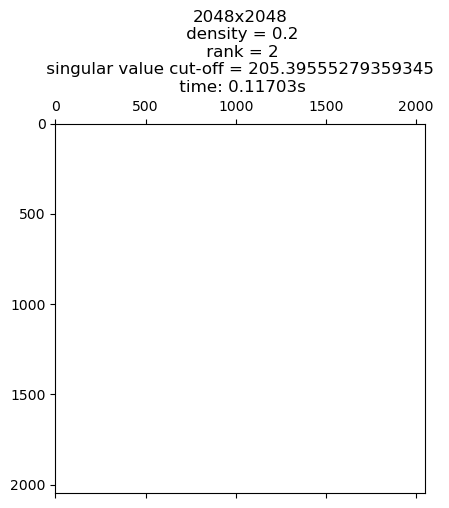

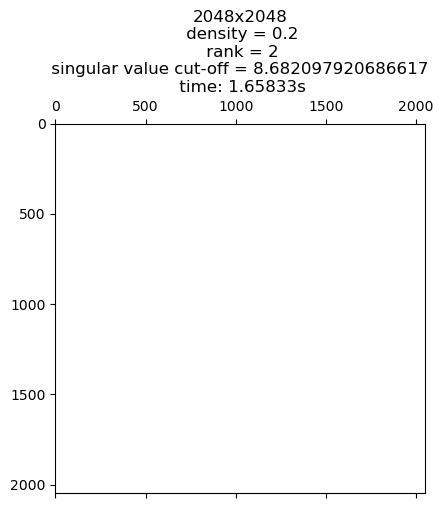

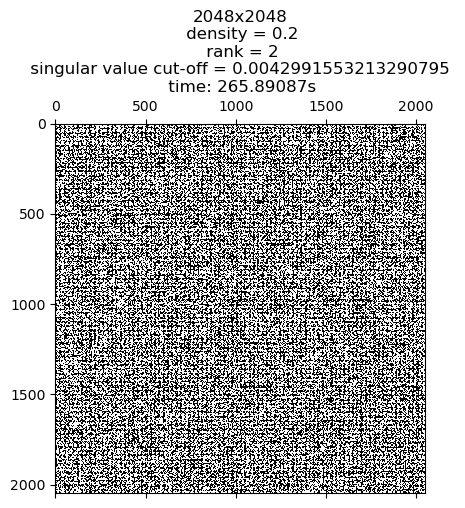

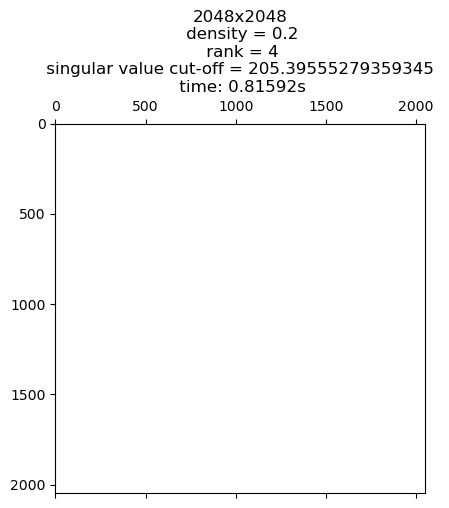

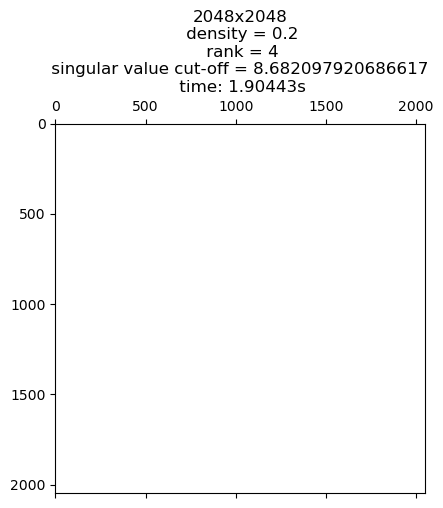

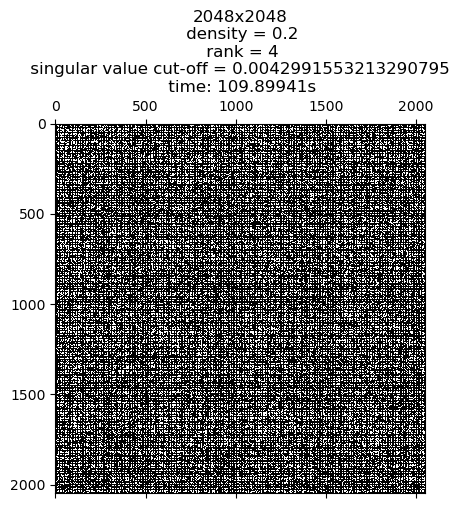

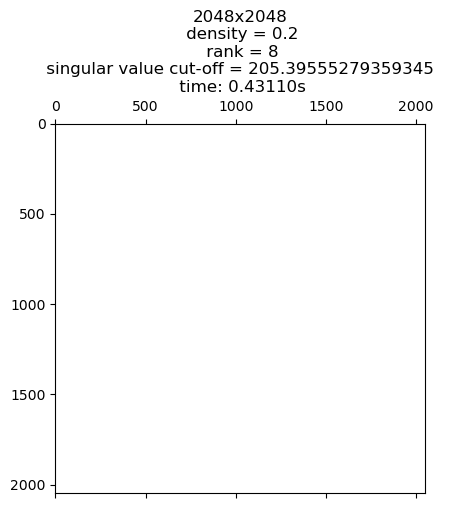

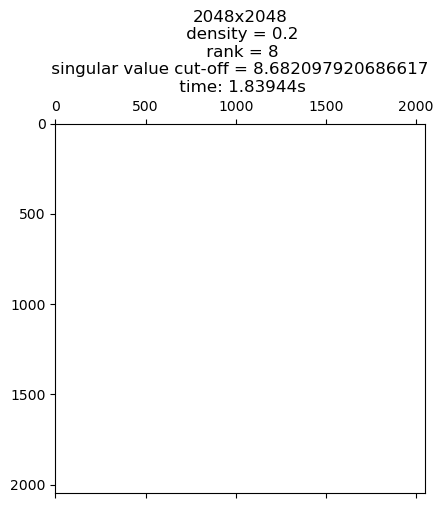

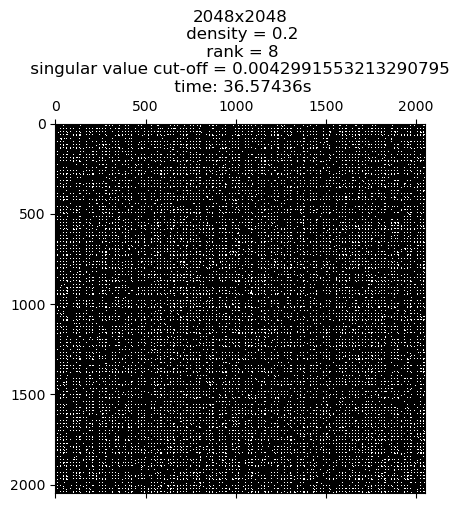

In [15]:
sizes = [2**i for i in range(8,12)]
densities = [0.01, 0.05, 0.1, 0.2]

results = {}
for density in densities:
    for size in sizes:
        matrix = random_matrix(size,size,density)
        
        _, S, _ = np.linalg.svd(matrix)
        singular_values = [('0', S[0]), ('n//2', S[size//2]), ('n', S[-1])]
        
        for b in [2,4,8]:
            for ind, singular_value in singular_values:
                start = time()
                tree = create_tree(matrix, b, singular_value)
                end = time()
                print(density, size, b, singular_value, end-start)
                
                ftime = f"{end - start:.5f}"
                plot_matrix(tree, matrix, title = f"{size}x{size}\n density = {density}\n rank = {b}\n singular value cut-off = {singular_value} \n time: {ftime}s")
                x = (density, size, b, ind)
                results[x] = end - start
                           
                #zrobić coś z wynikami
        

In [13]:
def filter_results(results, filters):
#filters - dict {'density': wartosc/None, 'size': wartosc/None, 'rank': wartosc/None, 'sval': wartosc/None}
    filtered_results = results.copy()
    
    hdict = {'density' : 0, 'size' : 1, 'rank': 2, 'sval' : 3}

    for param, value in filters.items():
        if value is not None:
            filtered_results = {key: val for key, val in filtered_results.items() if key[hdict[param]] == value}

    return filtered_results


In [14]:
filters = {'density': densities[0], 'size': sizes[0], 'rank': None, 'sval': None}
fres = filter_results(results, filters)
print(fres)

{(0.01, 256, 2, '0'): 0.012001991271972656, (0.01, 256, 2, 'n//2'): 0.4708211421966553, (0.01, 256, 2, 'n'): 0.6861529350280762, (0.01, 256, 4, '0'): 0.0030007362365722656, (0.01, 256, 4, 'n//2'): 0.38008618354797363, (0.01, 256, 4, 'n'): 0.4954822063446045, (0.01, 256, 8, '0'): 0.00401616096496582, (0.01, 256, 8, 'n//2'): 0.2961275577545166, (0.01, 256, 8, 'n'): 0.32314443588256836}
